# Forecasting Wearing-off

References:
* [Machine Learning Mastery's Time Series Tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [Tensorflow's Time Series Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)


# Load libraries

In [1]:
import time
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)


# Set Asia/Tokyo timezone
os.environ['TZ'] = 'Asia/Tokyo'
time.tzset()

run = datetime.now().strftime("%Y-%m-%d")

# Load configuration

In [2]:
# Participant to process
USER = 'participant13'
# USER = f'participant{sys.argv[1]}'

# Collection dataset
# COLLECTION = '2-person'
COLLECTION = '10-person'
COLLECTION = '3-person'

# Define base path
BASE_DATA_PATH = '/workspaces/data'

FIGSIZE = (30, 10)

In [3]:
# Choose features
# Garmin features
features = ['heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem',
            'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# FonLog features
# features += ['time_from_last_drug_taken', 'wo_duration']

# Additional features
# features += ['timestamp_hour', 'timestamp_dayofweek',
features += ['timestamp_dayofweek',
             'timestamp_hour_sin', 'timestamp_hour_cos']

TARGET_COLUMN = 'wearing_off'
features.append(TARGET_COLUMN)

columns = ['timestamp'] + features + ['participant']

# Normalize features
normalize_features = features

In [4]:
# Metrics & Other Hyperparameters
SHIFT = 4
RECORD_SIZE_PER_DAY = 96  # 60 minutes / 15 minutes * 24 hours

In [5]:
# Test set periods
test_set_horizons = {
  "participant1": ["2021-12-02 0:00", "2021-12-03 23:45"],
  "participant2": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant3": ["2021-11-25 0:00", "2021-11-26 23:45"],
  "participant4": ["2021-12-06 0:00", "2021-12-07 7:15"],
  "participant5": ["2021-11-28 0:00", "2021-11-29 23:45"],
  "participant6": ["2021-12-06 0:00", "2021-12-07 23:45"],
  "participant7": ["2021-12-12 0:00", "2021-12-13 9:45"],
  "participant8": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant9": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant10": ["2021-12-23 0:00", "2021-12-24 23:45"],
  "participant11": ["2023-01-30 0:00", "2023-01-31 23:45"],
  "participant12": ["2023-01-10 0:00", "2023-01-11 23:45"],
  "participant13": ["2023-01-29 0:00", "2023-01-30 23:45"],
}

# Load dataset

In [6]:
# Load participant's Excel file
dataset = pd.read_excel(f'{BASE_DATA_PATH}/{COLLECTION}/combined_data.xlsx',
                        index_col="timestamp",
                        usecols=columns,
                        engine='openpyxl')

# Fill missing data with 0
dataset.fillna(0, inplace=True)

# Filter by participant
dataset = dataset.query(f'participant == "{USER}"').drop(
    columns=['participant'])

# Visualize dataset

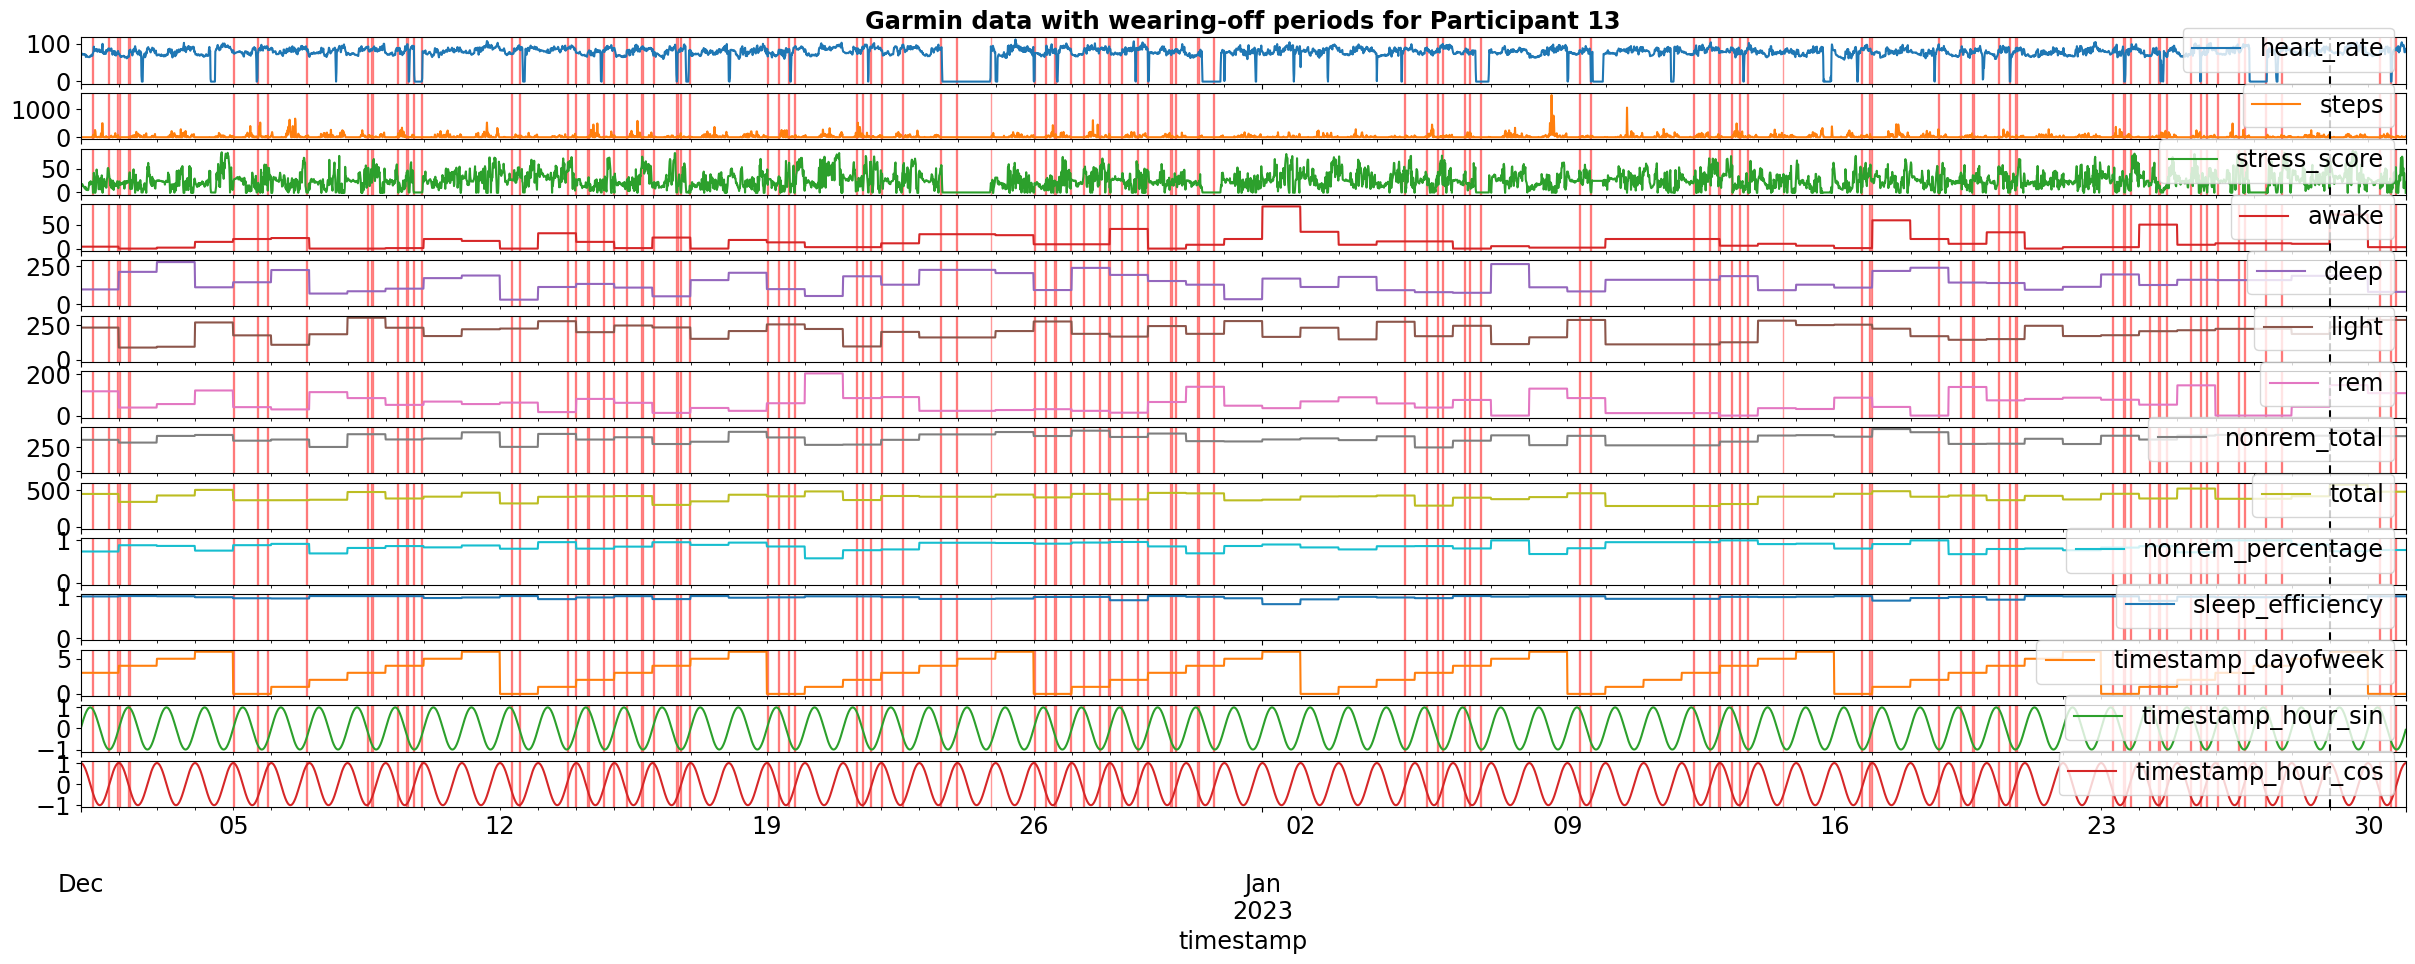

In [7]:
# Garmin features
features_to_visualize = ['heart_rate', 'steps', 'stress_score',
                         'awake', 'deep', 'light', 'rem',
                         'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# FonLog features
# features_to_visualize += ['time_from_last_drug_taken', 'wo_duration']

# Additional features
# features_to_visualize += ['timestamp_hour', 'timestamp_dayofweek',
features_to_visualize += ['timestamp_dayofweek',
                          'timestamp_hour_sin', 'timestamp_hour_cos']

axes = dataset.loc[:, features_to_visualize].plot(
  subplots=True, figsize=FIGSIZE)
for index, axis in enumerate(axes):
  if index == 0:
    axis.set_title(
      label='Garmin data with wearing-off periods for Participant {}'.format(
        USER.replace("participant", "")
      ),
      fontdict={
        'fontsize': 'xx-large',
        'fontweight': 'bold'
      }
    )

  column = dataset.columns[index]
  min_value = dataset[[column]].min()
  max_value = dataset[[column]].max()

  if min_value.values[0] > 0:
    min_value = 0

  axis.fill_between(
      x=dataset.index, y1=min_value, y2=max_value,
      where=dataset.wearing_off,
      alpha=0.4, color="red", transform=axis.get_xaxis_transform()
  )
  axis.legend([column], loc="lower right", fontsize='xx-large')
  axis.tick_params(axis='both', which='both', labelsize='xx-large')
  axis.set_xlabel(xlabel=dataset.index.name, fontsize='xx-large')

  # Add vertical line at test_horizon[0]
  axis.axvline(x=test_set_horizons[USER][0], color='black', linestyle='--')

plt.show()

In [8]:
# plot heatmap of wearing-off per day per hour
dataset.pivot_table(index=dataset.index.date,
                    columns=dataset.index.hour,
                    values='wearing_off',
                    aggfunc='sum'
                    ).fillna(0).astype(int).style.background_gradient(cmap='Reds', axis=1)

timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
2022-12-01,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,4
2022-12-02,4,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-12-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-12-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-12-05,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,4,0,0
2022-12-06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
2022-12-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2022-12-08,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0
2022-12-09,0,0,0,0,0,0,0,4,0,0,0,0,0,4,0,0,0,4,0,0,0,0,4,0
2022-12-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
from scipy import stats

# Check if there is significant diffence in each features between wearing-off and non wearing-off periods
with_significant_difference = []
without_significant_difference = []

for feature in features:
  result = stats.ttest_ind(
      dataset.query('wearing_off == True')[feature],
      dataset.query('wearing_off == False')[feature]
    ).pvalue < 0.05
  if result:
    with_significant_difference.append(feature)
  else:
    without_significant_difference.append(feature)

print('Features with significant difference:')
print(with_significant_difference)
print()
print('Features without significant difference:')
print(without_significant_difference)

Features with significant difference:
['steps', 'awake', 'deep', 'light', 'nonrem_total', 'total', 'sleep_efficiency', 'timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos', 'wearing_off']

Features without significant difference:
['heart_rate', 'stress_score', 'rem', 'nonrem_percentage']


/tmp/ipykernel_28364/2723392963.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result = stats.ttest_ind(


# Split dataset into train and test sets

## Split by train-test split

In [10]:
train_df = dataset.loc[
  dataset.index < test_set_horizons[USER][0]
].copy()
test_df = dataset.loc[test_set_horizons[USER][0]:].copy()

scale_pos_weight = train_df.wearing_off.value_counts(
)[0] / train_df.wearing_off.value_counts()[1]

# # Divide train_df to train_df and validation_df where validation_df is the last 20% of train_df
# Get validation_df 1 day before test_horizon[0]
validation_df = train_df.iloc[RECORD_SIZE_PER_DAY * -1:, :].copy()
# Get train_df without validation_df
train_df = train_df.iloc[:RECORD_SIZE_PER_DAY * -1, :].copy()

#### Print statistics

In [11]:
print(f'''
train_df: {train_df.shape} or {train_df.shape[0] / RECORD_SIZE_PER_DAY} days
validation_df: {validation_df.shape} or {validation_df.shape[0] / RECORD_SIZE_PER_DAY} days
test_df: {test_df.shape} or {test_df.shape[0] / RECORD_SIZE_PER_DAY} days
''')


train_df: (5568, 15) or 58.0 days
validation_df: (96, 15) or 1.0 days
test_df: (192, 15) or 2.0 days



In [12]:
# Get the percentage of wearing_off in dataset
print(
  round(dataset.wearing_off.value_counts(normalize=True) * 100, 3)
)

# Get the percentage of wearing_off in dataset per day
print(
  round(
    dataset.wearing_off.value_counts(
        normalize=True) / RECORD_SIZE_PER_DAY * 100,
    3
  )
)

0    93.528
1     6.472
Name: wearing_off, dtype: float64
0    0.974
1    0.067
Name: wearing_off, dtype: float64


In [13]:
# # Slice the test_df for every hour
# print(len(test_df.iloc[::SHIFT, :]))
# display(test_df.iloc[::SHIFT, :])

# Transform series_to_supervised

In [14]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  var_names = data.columns
  n_vars = len(var_names)
  df = pd.DataFrame(data)
  cols, names = list(), list()  # new column values, new columne names

  # input sequence (t-i, ... t-1)
  # timesteps before (e.g., n_in = 3, t-3, t-2, t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += list(
        map(lambda var_name: f'{var_name}(t-{i})', var_names)
    )

  # forecast sequence (t, t+1, ... t+n)
  # timesteps after (e.g., n_out = 3, t, t+1, t+2)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += list(map(lambda var_name: f'{var_name}(t)', var_names))
    else:
      names += list(map(lambda var_name: f'{var_name}(t+{i})', var_names))

  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [15]:
# Split into X and y
def split_x_y(df, target_columns, SHIFT=SHIFT):
  # Drop extra columns i.e., (t+1), (t+2), (t+3), (t+4)
  regex = r".*\(t\+[1-{SHIFT}]\)$"  # includes data(t)
  # regex = r"\(t(\+([1-{SHIFT}]))?\)$" # removes data(t)

  # Drop extra columns except target_columns
  df.drop(
    [x for x in df.columns if re.search(regex, x) and x not in target_columns],
    axis=1, inplace=True
  )

  # Split into X and y
  y = df[target_columns].copy()
  X = df.drop(target_columns, axis=1)

  return (X, y)

In [16]:
# # Plot train, validation, and test's wearing off in different colors
# train_df.heart_rate.plot(figsize=(20, 5), color='blue')
# validation_df.heart_rate.plot(figsize=(20, 5), color='orange')
# test_df.heart_rate.plot(figsize=(20, 5), color='green')

In [17]:
# # Check correlation of heart_rate with wearing_off
# dataset[['heart_rate', 'wearing_off']].corr()

# # Plot heart_rate with wearing-off with wearing-off in secondary y-axis
# dataset[['heart_rate']].plot(figsize=FIGSIZE)

# # Add wearing-off as shade
# plt.fill_between(
#   x=dataset.index,
#   y1=dataset.heart_rate.min(),
#   y2=dataset.heart_rate.max(),
#   where=dataset.wearing_off,
#   color='red',
#   alpha=0.5
# )

# # Add lower shade around wearing-off periods (-1 hour, +hour)
# plt.fill_between(
#   x=dataset.index,
#   y1=dataset.heart_rate.min(),
#   y2=dataset.heart_rate.max(),
#   where=wearing_off_shifted,
#   color='blue',
#   alpha=0.1
# )

# # plt.show()

# Check Input Horizons vs F1-Score

In [18]:
def plot_forecast(ground_truth_y, ground_truth_X, forecast_df):
  # Plot `ground_truth.values.ravel()` and `preds_proba` on the same plot to show the difference
  plt.figure(figsize=FIGSIZE)
  plt.plot(ground_truth_y,
           label='actual', color='red', marker='o')
  plt.plot(forecast_df.forecasted_wearing_off_probability,
           label='forecasted', color='blue', marker='o')
  # plt.plot(forecasts_output.forecasted_wearing_off,
  #          label='predicted', color='blue', marker='o')
  plt.legend()

  # Dashed horizontal line at 0.5
  plt.axhline(0.5, linestyle='--', color='gray')

  # Dashed vertical lines on each hour
  for i in ground_truth_X.index:
    if pd.Timestamp(i).minute == 0:
      plt.axvline(i, linestyle='--', color='gray')

  # y-axis label Wearing-off Forecast Probability
  plt.ylabel('Wearing-off Forecast Probability')

  plt.show()


def plot_confusion_matrix(ground_truth_y, ground_truth_X, forecast_df):
  # Plot confusion matrix
  from sklearn.metrics import confusion_matrix
  import seaborn as sns

  LABELS = ['No Wearing-off', 'Wearing-off']

  conf_matrix = confusion_matrix(ground_truth_y.values.ravel(),
                                 forecast_df.forecasted_wearing_off)
  plt.figure(figsize=(FIGSIZE))
  sns.heatmap(conf_matrix, xticklabels=LABELS,
              yticklabels=LABELS, annot=True, fmt=".2f")
  plt.title("Confusion matrix")
  plt.ylabel('True class')
  plt.xlabel('Forecasted class')
  plt.show()

In [19]:
def make_forecasts(model, test_X):
  # Make forecasts
  forecasts = model.predict(
    pd.concat([
      # train_X_scaled_normalized.tail(4),
      test_X
    ])
  )

  # Get the probability for 1s class
  forecasts_proba = model.predict_proba(
    pd.concat([
      # train_X_scaled_normalized.tail(4),
      test_X
    ])
  )[:, 1]

  forecasts_output = pd.DataFrame(
    {
      'patient_id': [USER] * len(forecasts),
      'timestamp': test_X.index,
      'forecasted_wearing_off': forecasts,
      'forecasted_wearing_off_probability': forecasts_proba
    },
    columns=['patient_id', 'timestamp', 'forecasted_wearing_off',
             'forecasted_wearing_off_probability'],
    index=test_X.index
  )

  return forecasts_output

In [20]:
def gradient(y_pred, y_true):
  '''Compute the gradient of log likelihood'''
  y_true = y_true
  y_pred = 1.0 / (1.0 + np.exp(-y_pred))
  return y_true - y_pred


def hessian(y_pred, y_true):
  '''Compute the hessian of log likelihood'''
  y_true = y_true
  y_pred = 1.0 / (1.0 + np.exp(-y_pred))
  return y_pred * (1.0 - y_pred)


# Make new objective function
def objective_function(y_pred, y_true, model=None):
  '''Compute log likelihood'''
  y_true = y_true
  y_pred = 1.0 / (1.0 + np.exp(-y_pred))
  grad = gradient(y_pred, y_true)
  hess = hessian(y_pred, y_true)

  if model is not None:
    sample_weight = model.get_booster().get_weight()
    return grad, hess, sample_weight
  else:
    return grad, hess


def negative_sampling_with_log_odds_correction(train_X, train_y, sampling_rate=0.5):
  # Slice train_y to get only the 1s
  negative_y = train_y[train_y.values == 0]
  positive_y = train_y[train_y.values == 1]

  # Slice train_X to get only the 1s
  negative_X = train_X.loc[negative_y.index]
  positive_X = train_X.loc[positive_y.index]

  # Sample the negative class to have the same number of samples as the positive class
  sampled_negative_X = negative_X.sample(len(positive_X), random_state=4)
  sampled_negative_y = negative_y.loc[sampled_negative_X.index]

  balanced_X = pd.concat([
    positive_X,
    sampled_negative_X
  ])

  balanced_y = pd.concat([
    positive_y,
    sampled_negative_y
  ])

  # Train a pilot model
  pilot_model = XGBClassifier(random_state=4)

  # Fit pilot model
  pilot_model.fit(balanced_X, balanced_y)

  # Get forecast probability of negative_X
  scored_negative_X = pd.DataFrame(
    pilot_model.predict_proba(negative_X)[:, 1],
    index=negative_X.index,
    columns=['score']
  )

  # For each row in scored_negative_X,
  #   Generate a random number u between 0 and 1
  #   If u < score * p, then keep row; otherwise, drop row

  # sampling_rate is the desired proportion of negative samples to keep

  # Generate random numbers
  random_numbers = np.random.rand(len(scored_negative_X))

  # Keep rows where random_numbers < scored_negative_X.score * sampling_rate
  high_scores = scored_negative_X.loc[random_numbers <
                                      scored_negative_X.score * sampling_rate].copy()

  # Keep negative_x with high scores
  high_score_negative_X = negative_X.loc[high_scores.index]
  high_score_negative_y = negative_y.loc[high_scores.index]

  # Combine positive_X and high_score_negative_X for subsampled training
  subsampled_X = pd.concat([
    positive_X,
    high_score_negative_X
  ])

  subsampled_y = pd.concat([
    positive_y,
    high_score_negative_y
  ])

  # Create a dataframe of 1s based on positive_y
  ones = pd.DataFrame(
    np.ones(len(positive_y)),
    index=positive_y.index,
    columns=['score']
  )

  # Combine ones and high_scores
  sampling_probability = pd.concat([
    ones,
    high_scores
  ])
  # sampling_probability = 1 / (sampling_probability.score).ravel()
  # sampling_probability = -np.log10(sampling_probability.score).ravel()
  sampling_probability = sampling_probability.score.ravel()

  # Train a subsampled model
  subsampled_model = XGBClassifier(random_state=4, objective=objective_function)

  # Fit subsampled model with sampling_probability weights
  subsampled_model.fit(subsampled_X, subsampled_y,
                       sample_weight=sampling_probability)
  #  sample_weight=sampling_probability)

  return subsampled_model

In [21]:
# Increase plt font size by 20% based on default font size
plt.rcParams.update({'font.size': plt.rcParams['font.size'] * 1.3})

# Reset plt font size
# plt.rcParams.update({'font.size': plt.rcParamsDefault['font.size']})

In [22]:
def scale_data(X):
  scaler = MinMaxScaler(feature_range=(0, 1))
  X_scaled = scaler.fit_transform(X)
  X_scaled = pd.DataFrame(X_scaled,
                          columns=X.columns,
                          index=X.index)

  return X_scaled

N_IN: 4
BASE XGBOOST MODEL


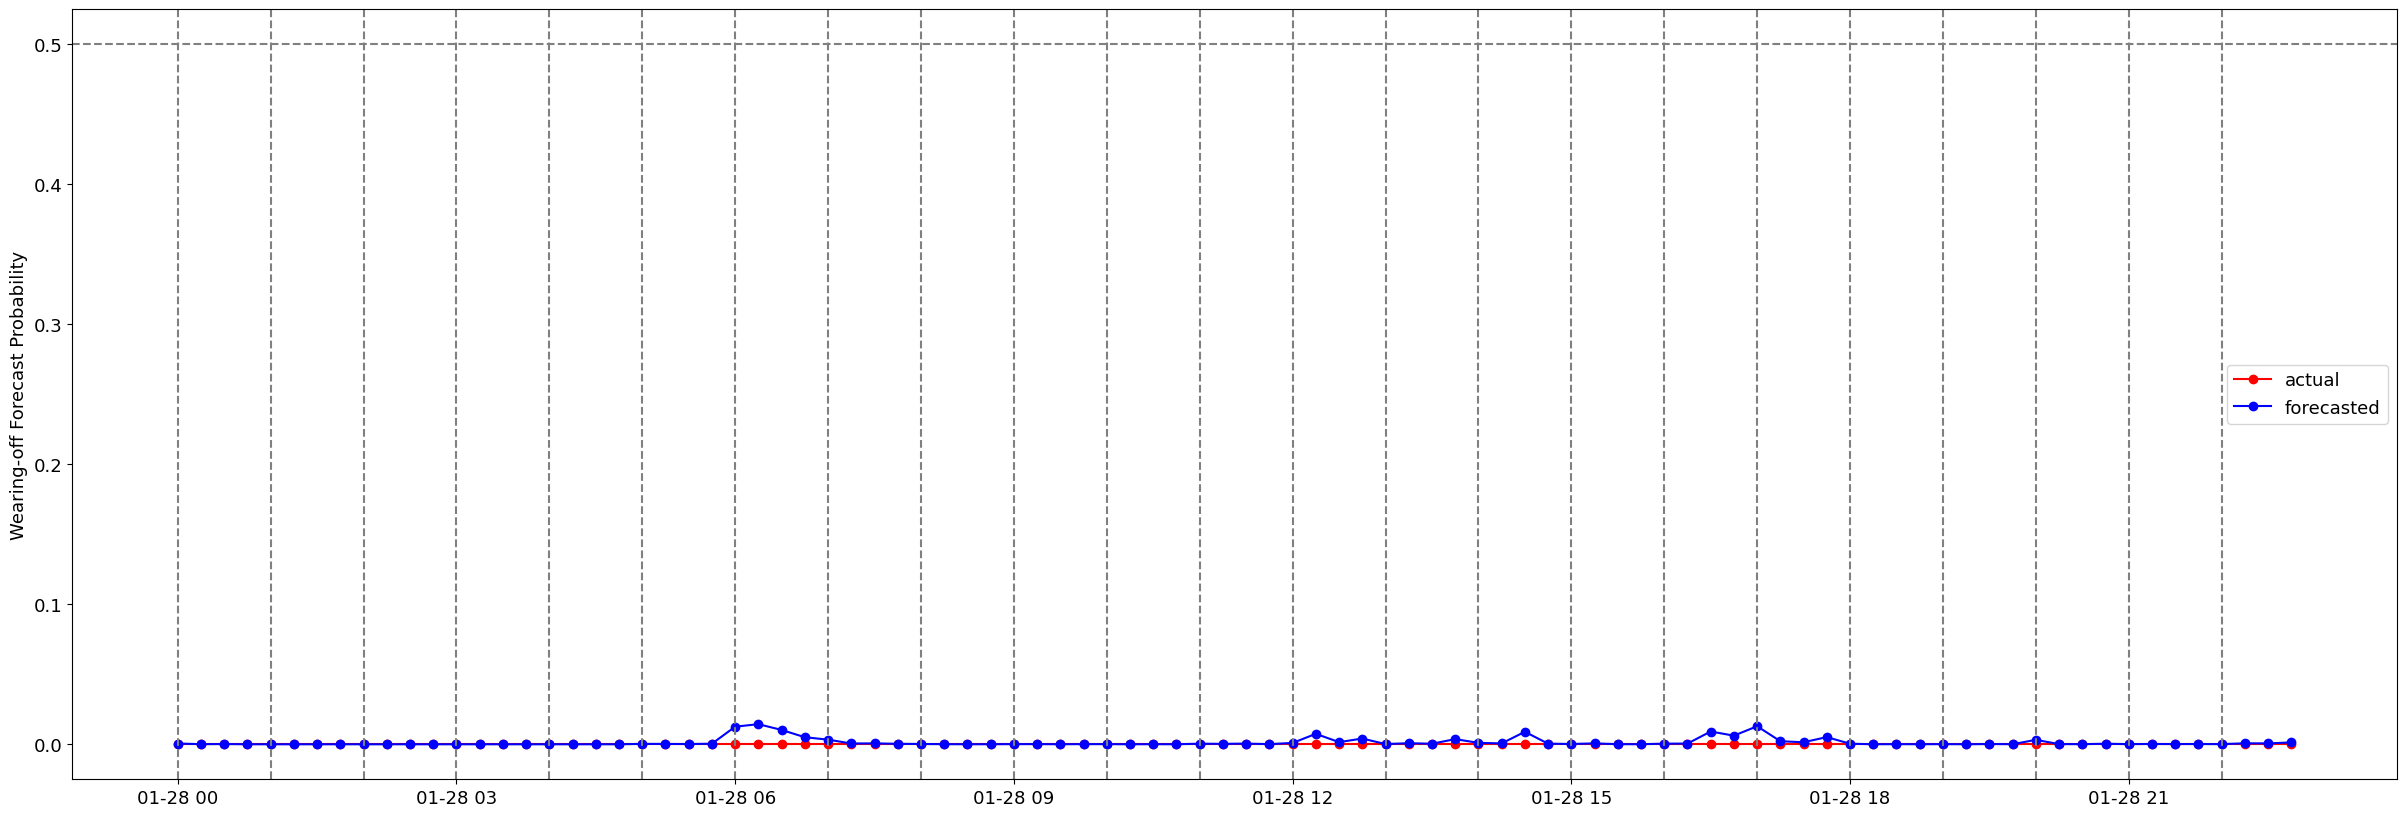

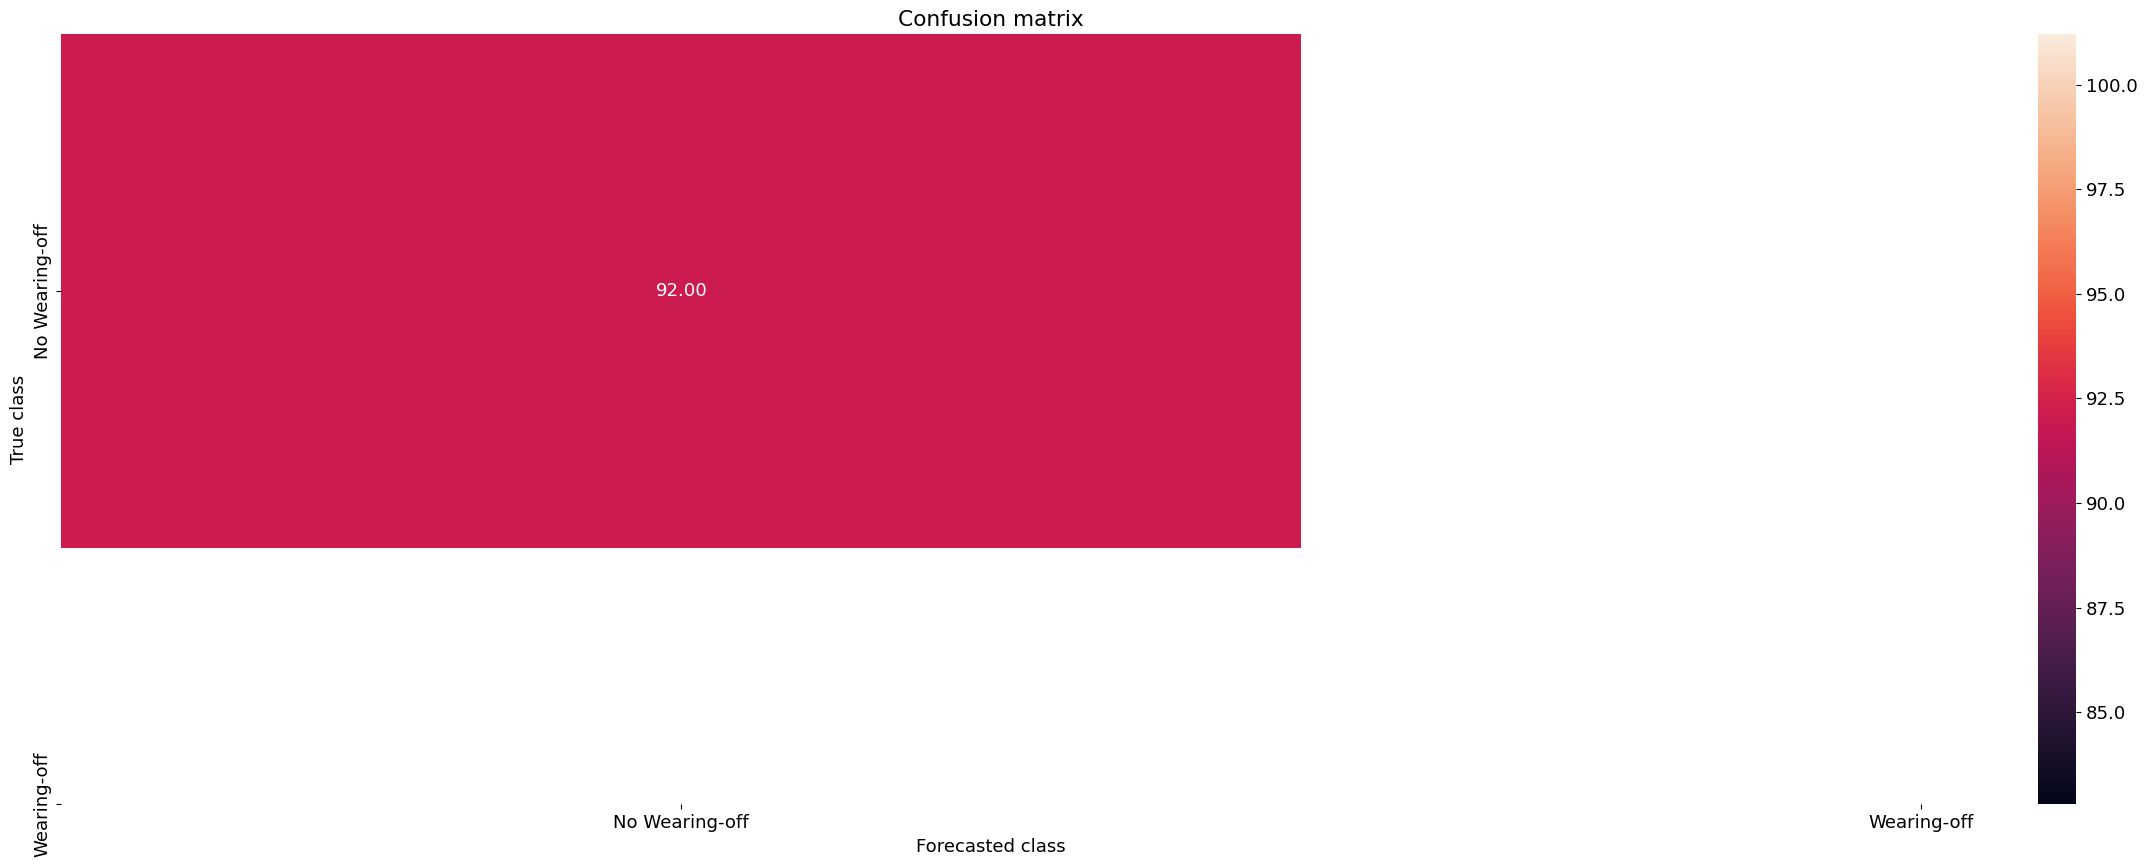

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 8
BASE XGBOOST MODEL


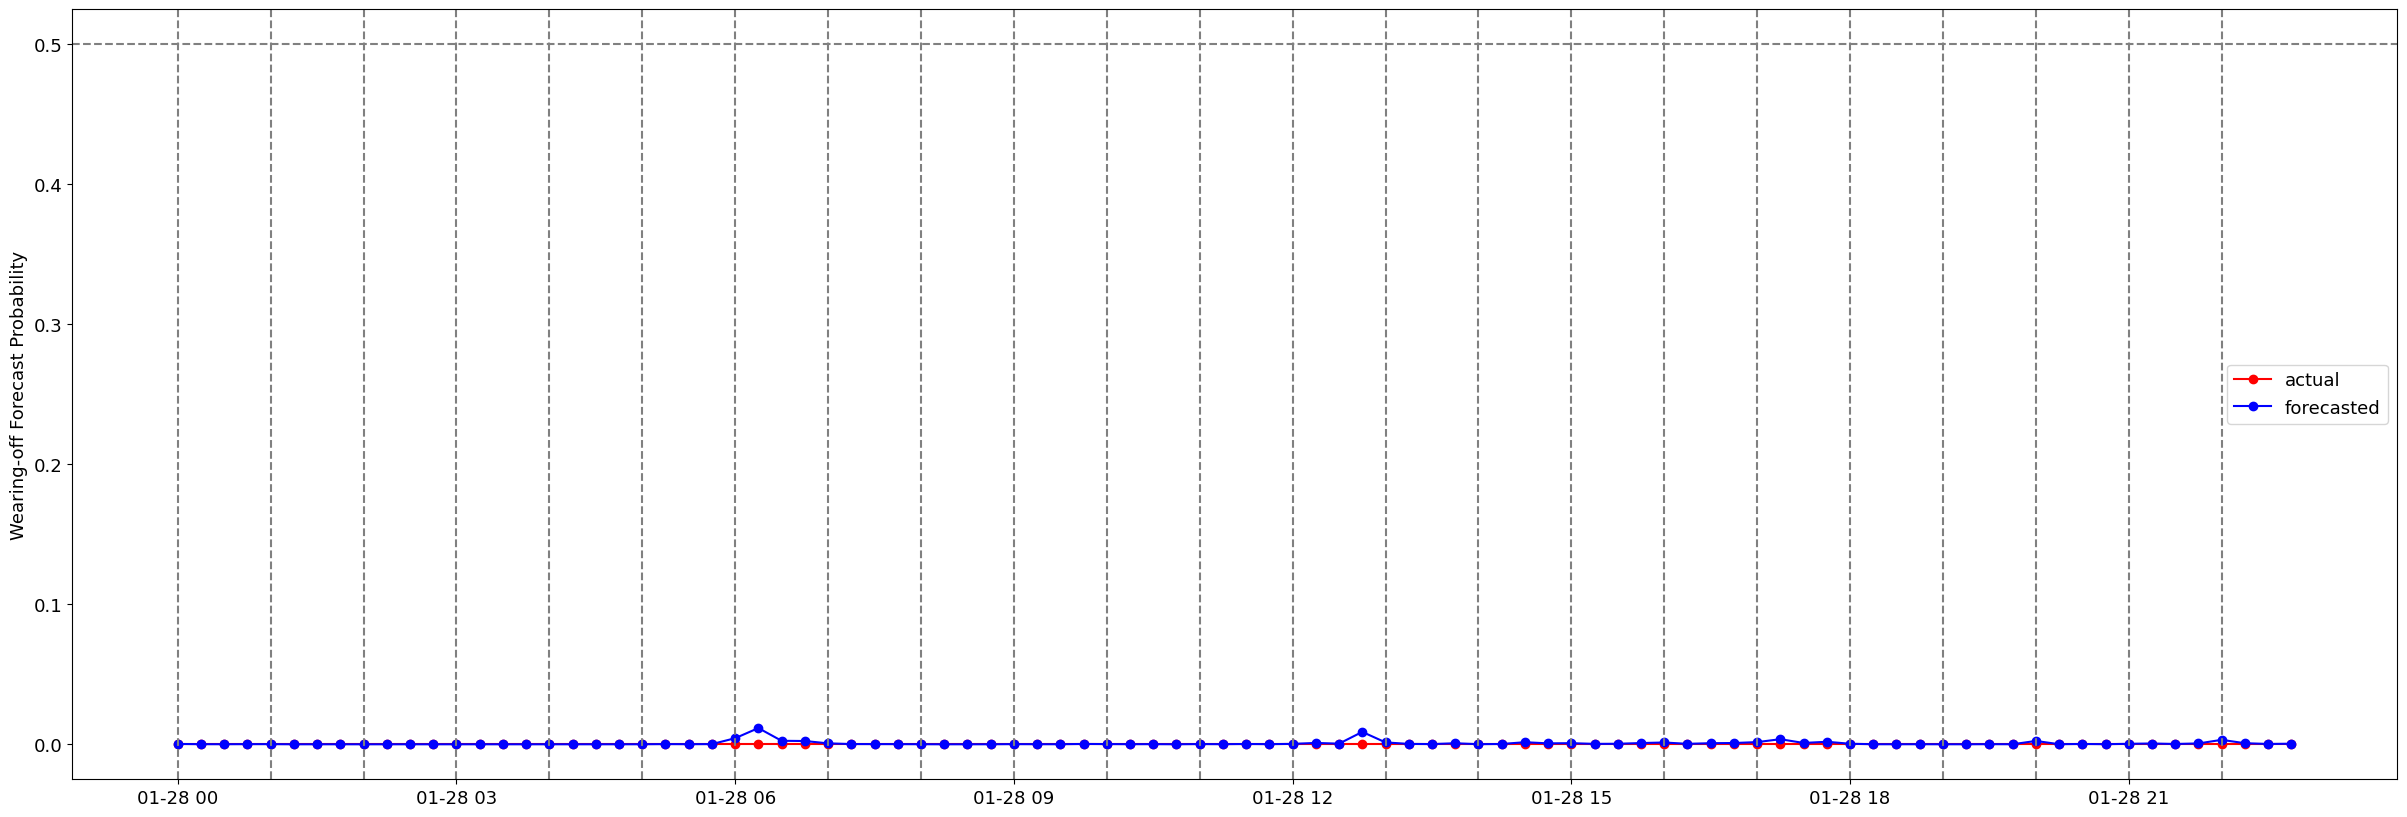

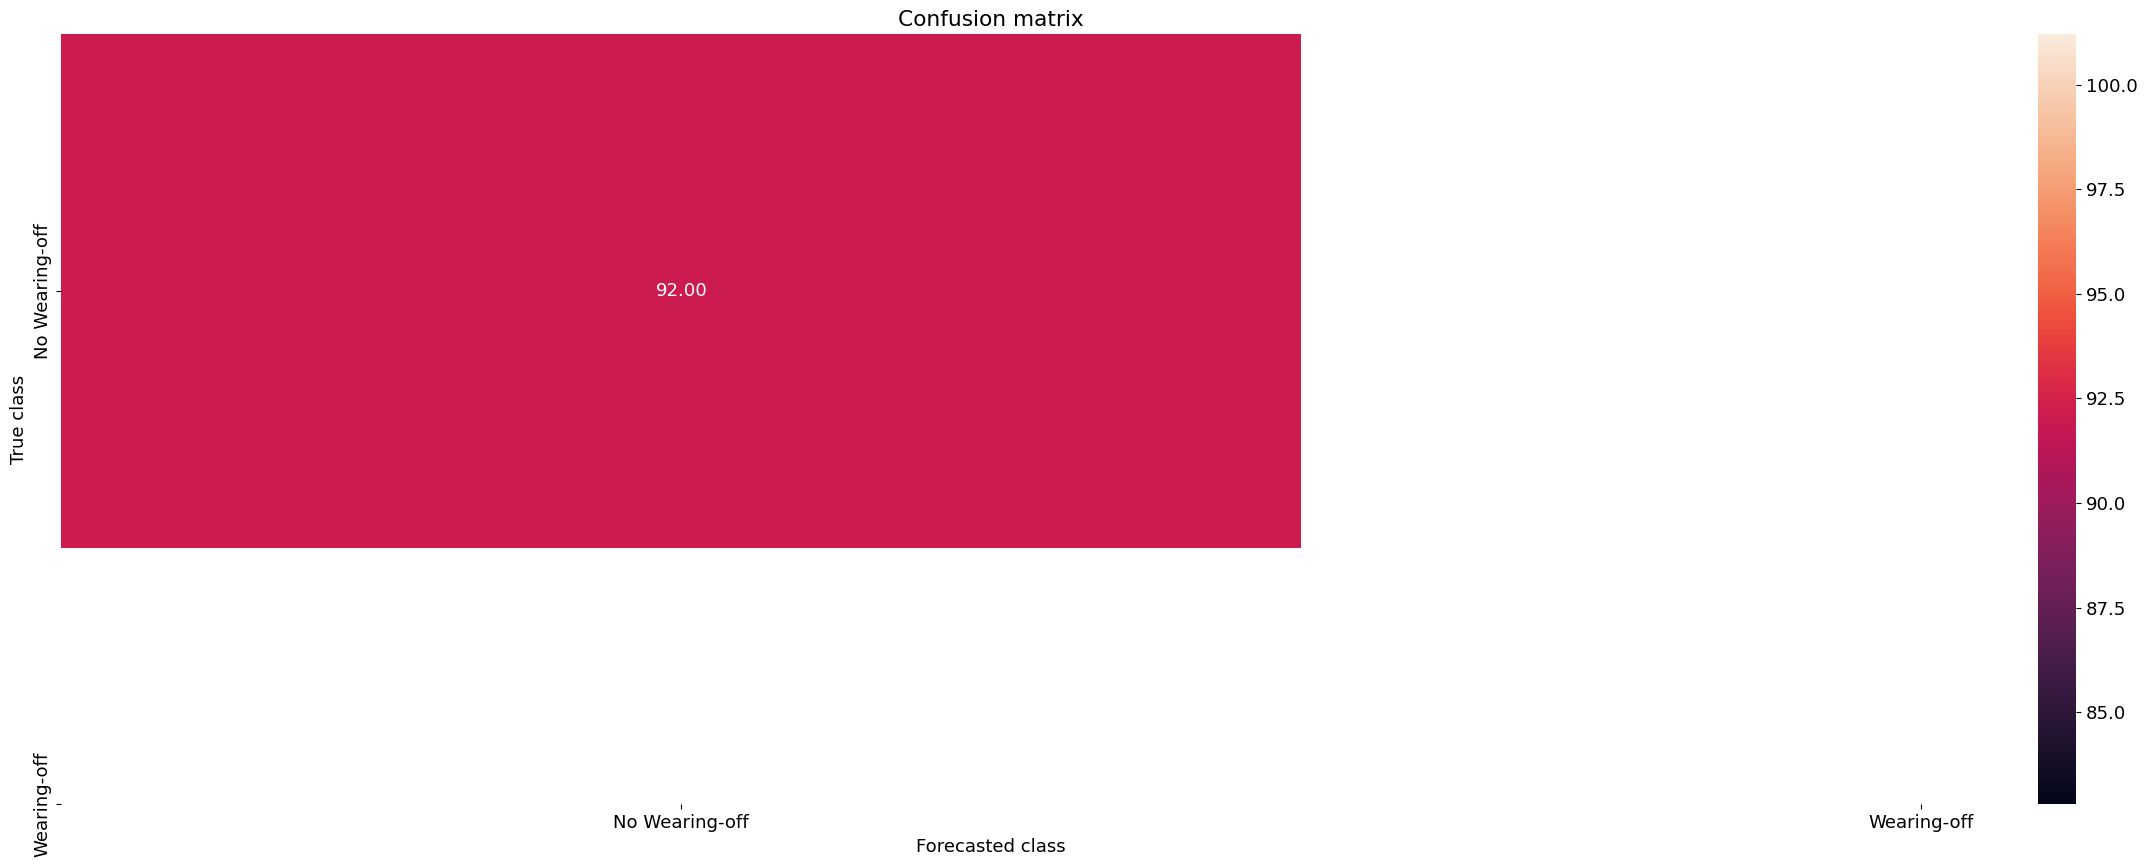

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 12
BASE XGBOOST MODEL


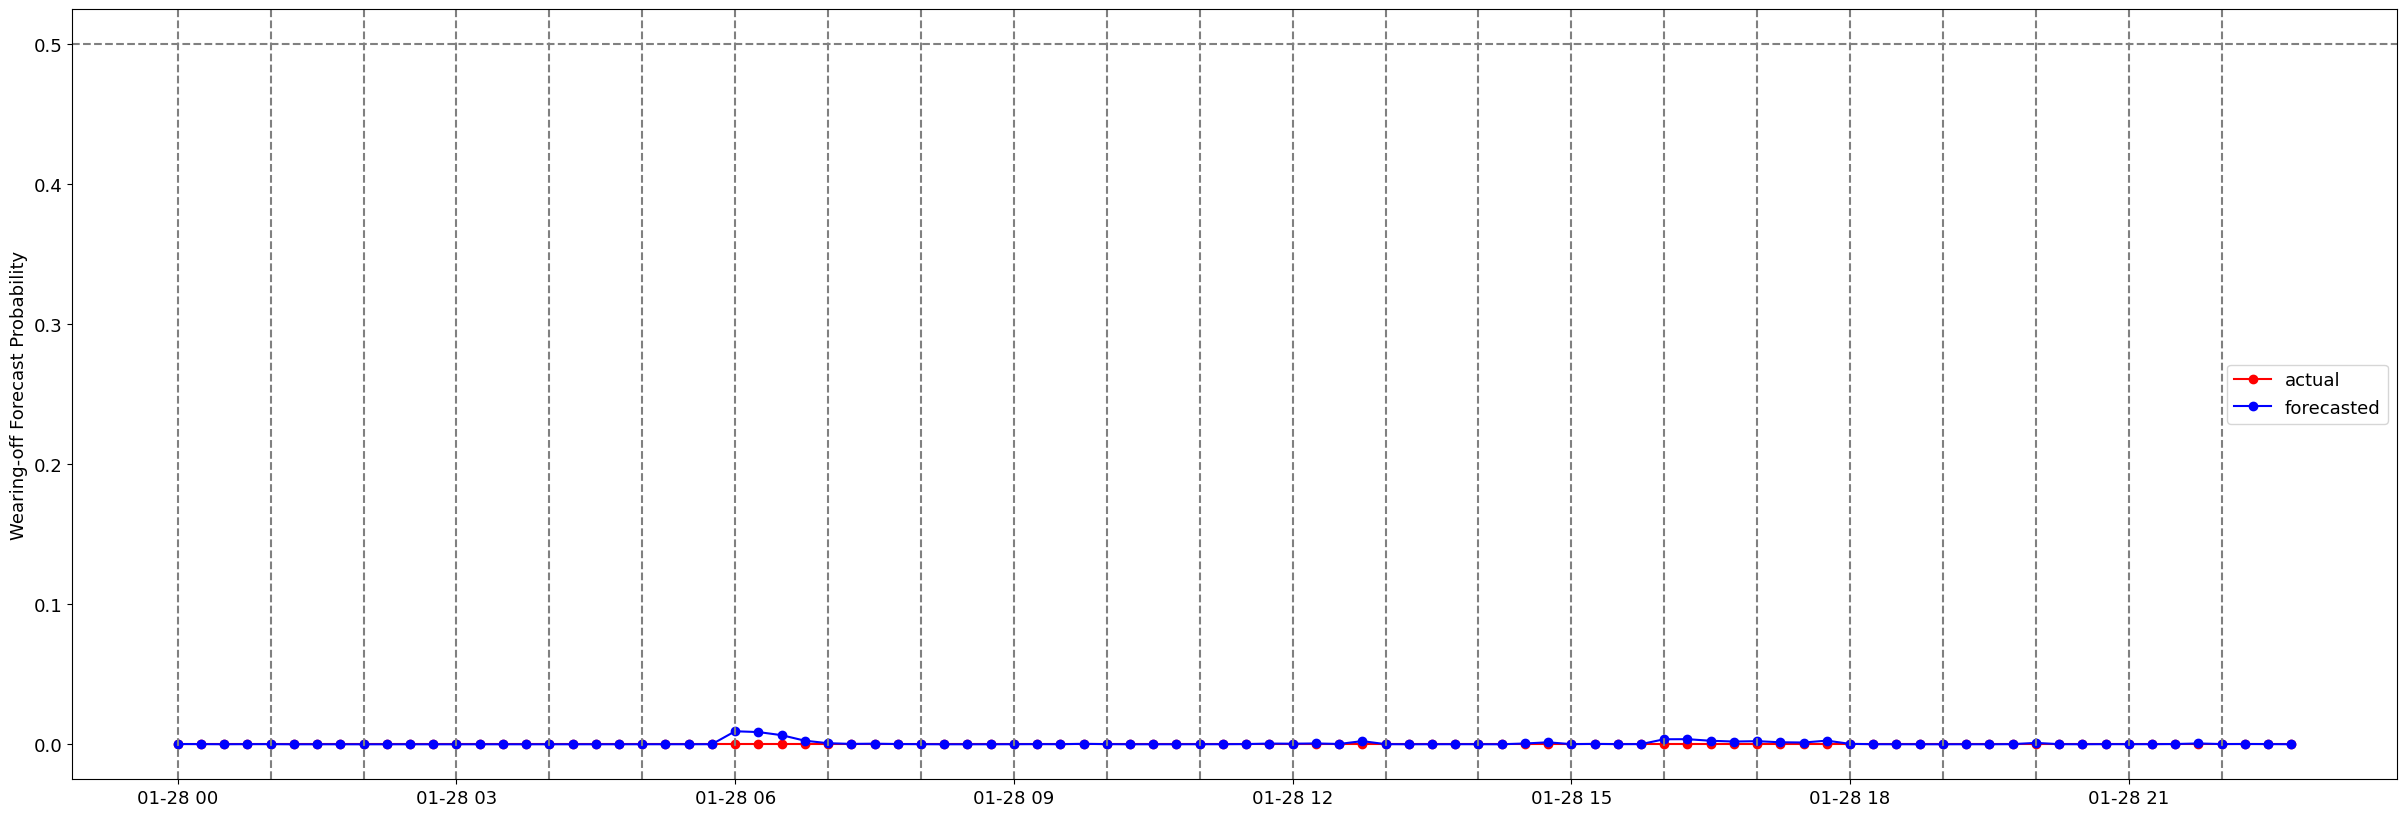

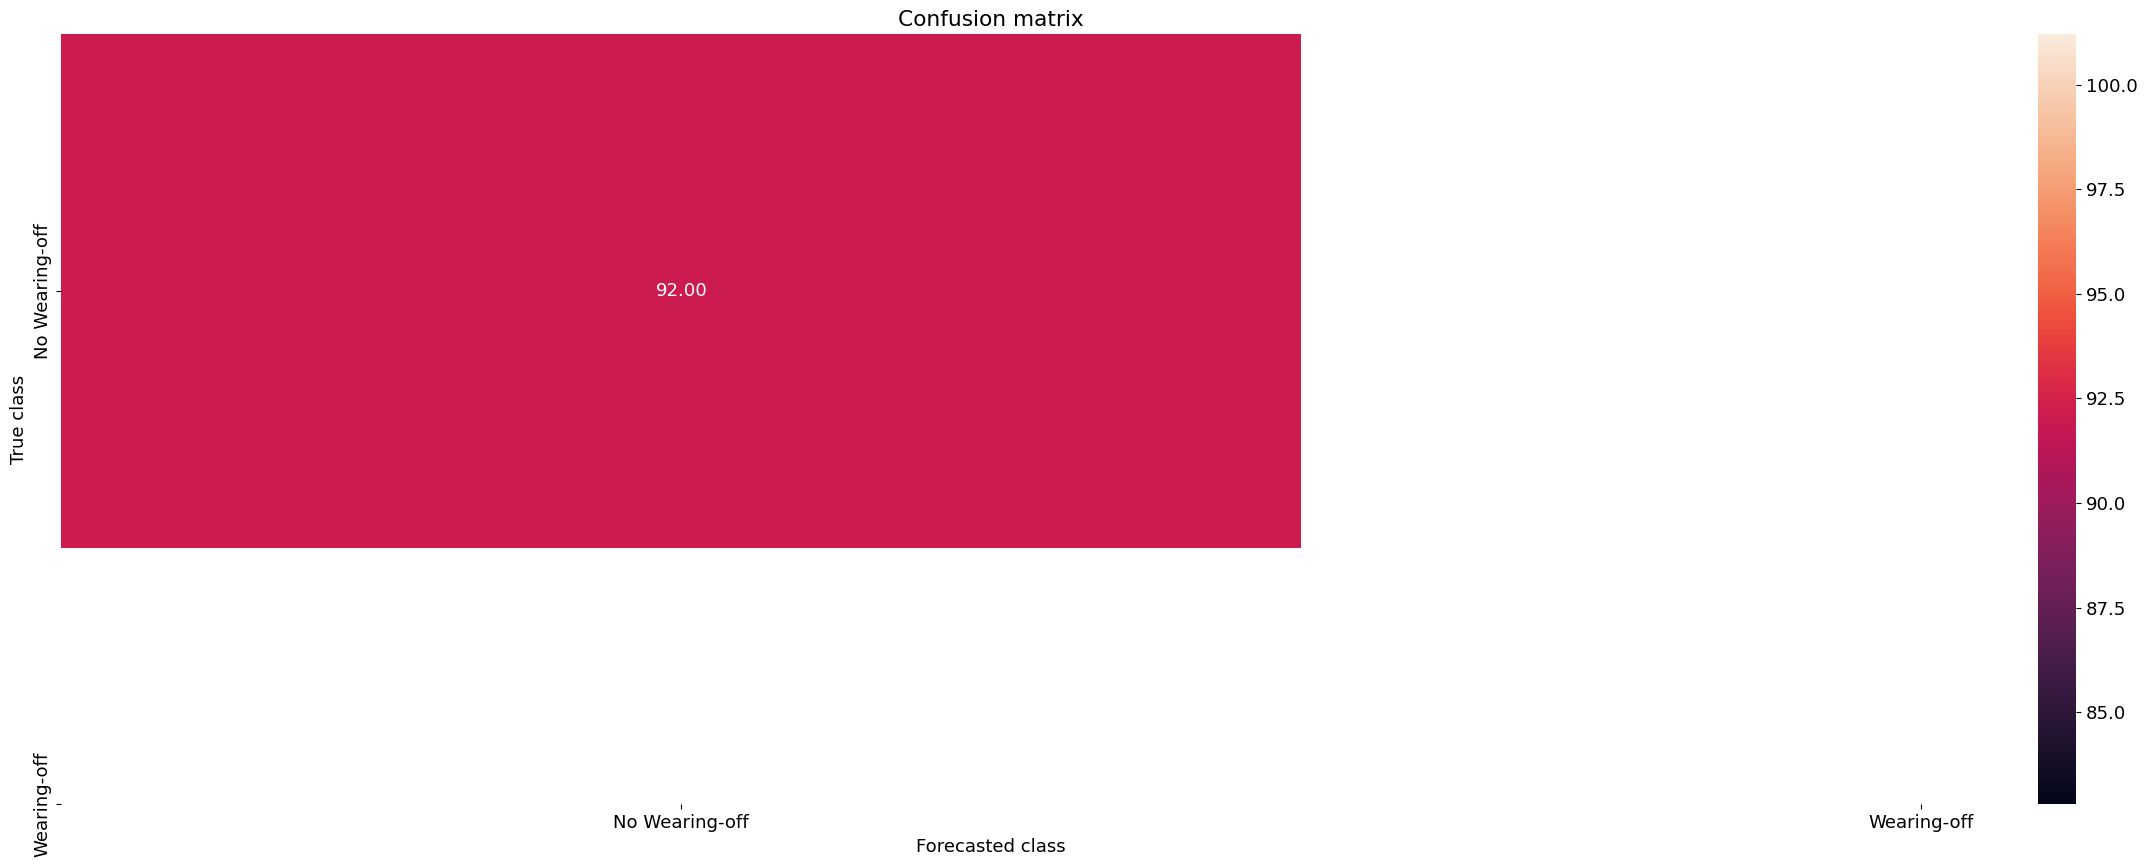

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 16
BASE XGBOOST MODEL


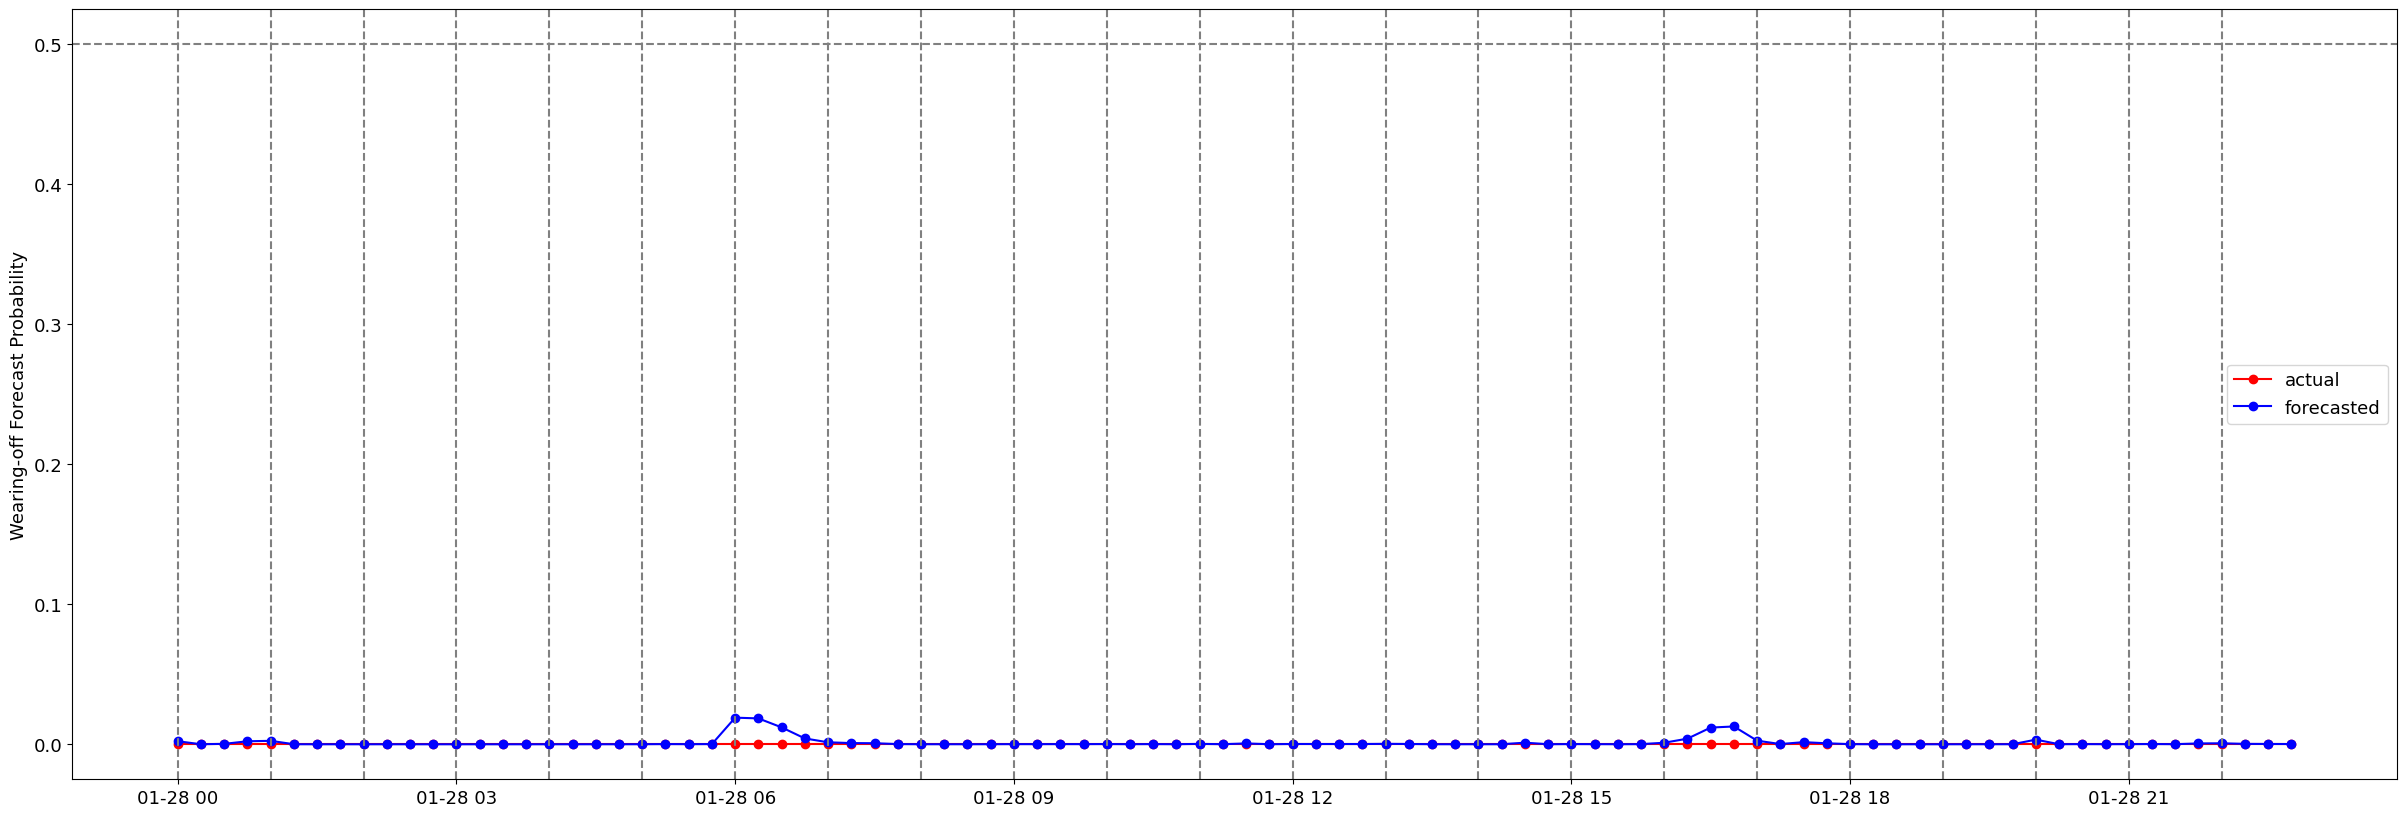

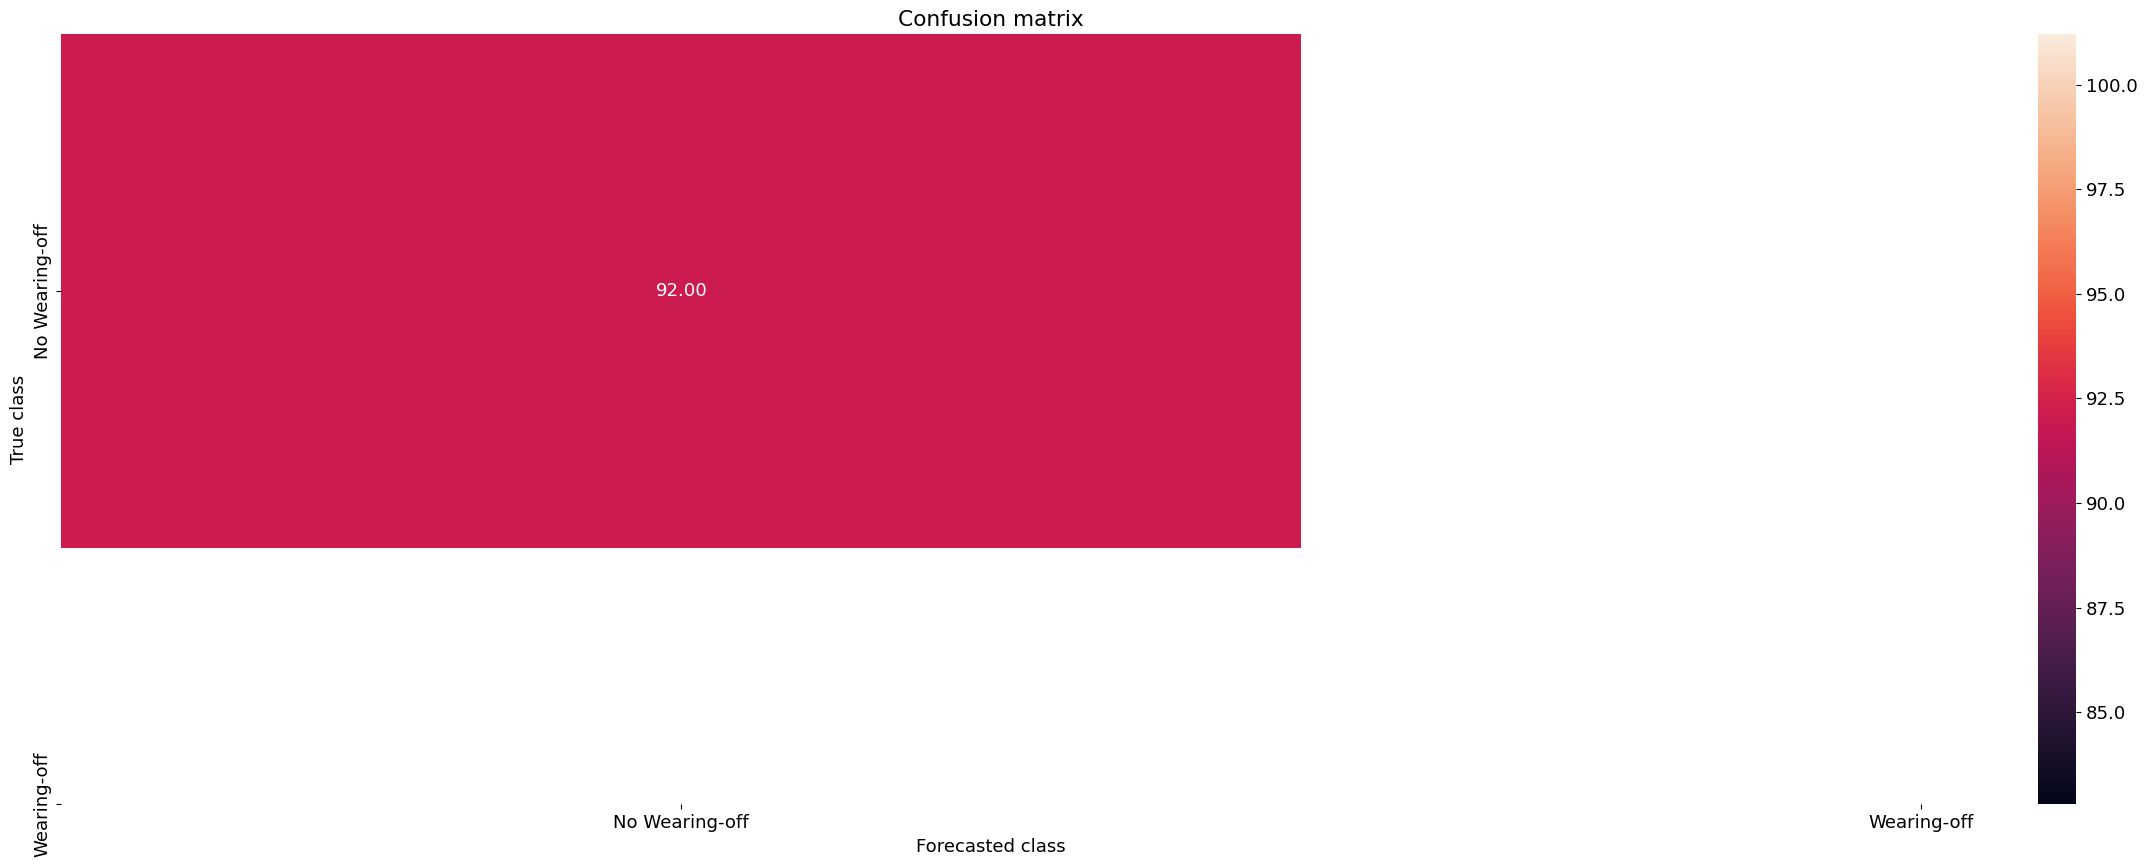

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 20
BASE XGBOOST MODEL


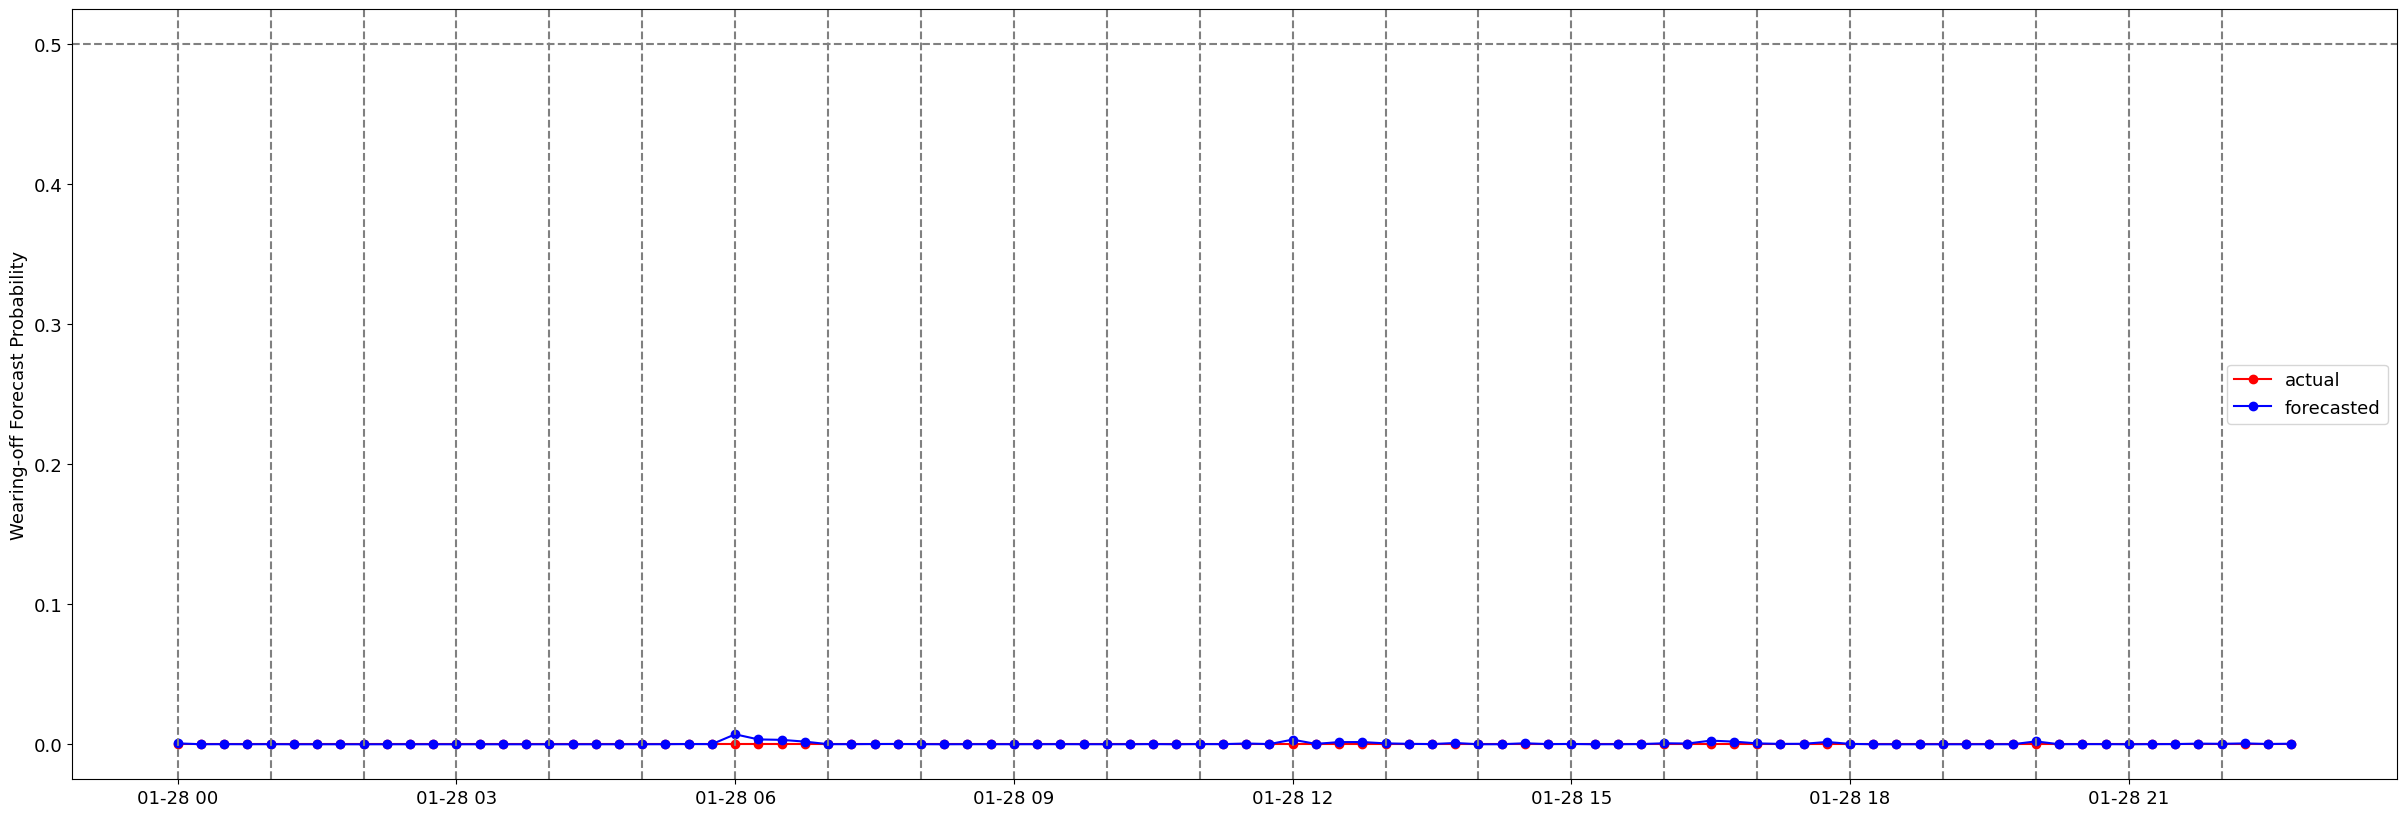

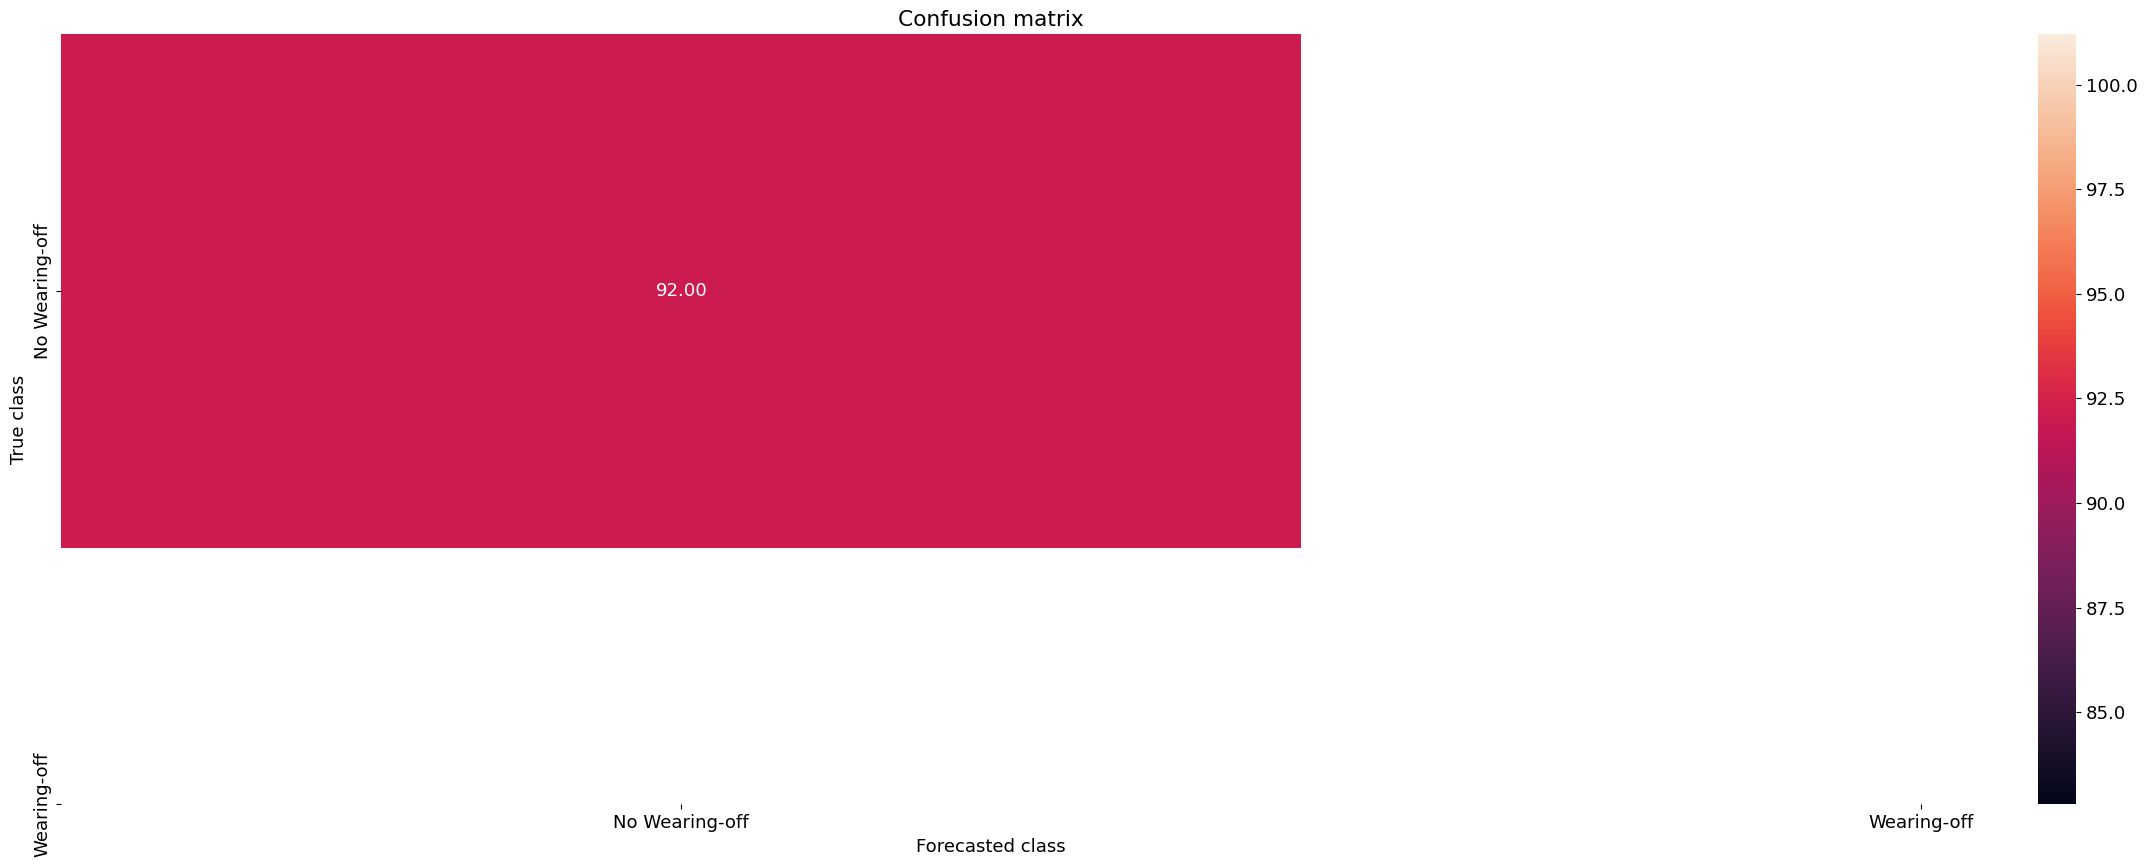

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 24
BASE XGBOOST MODEL


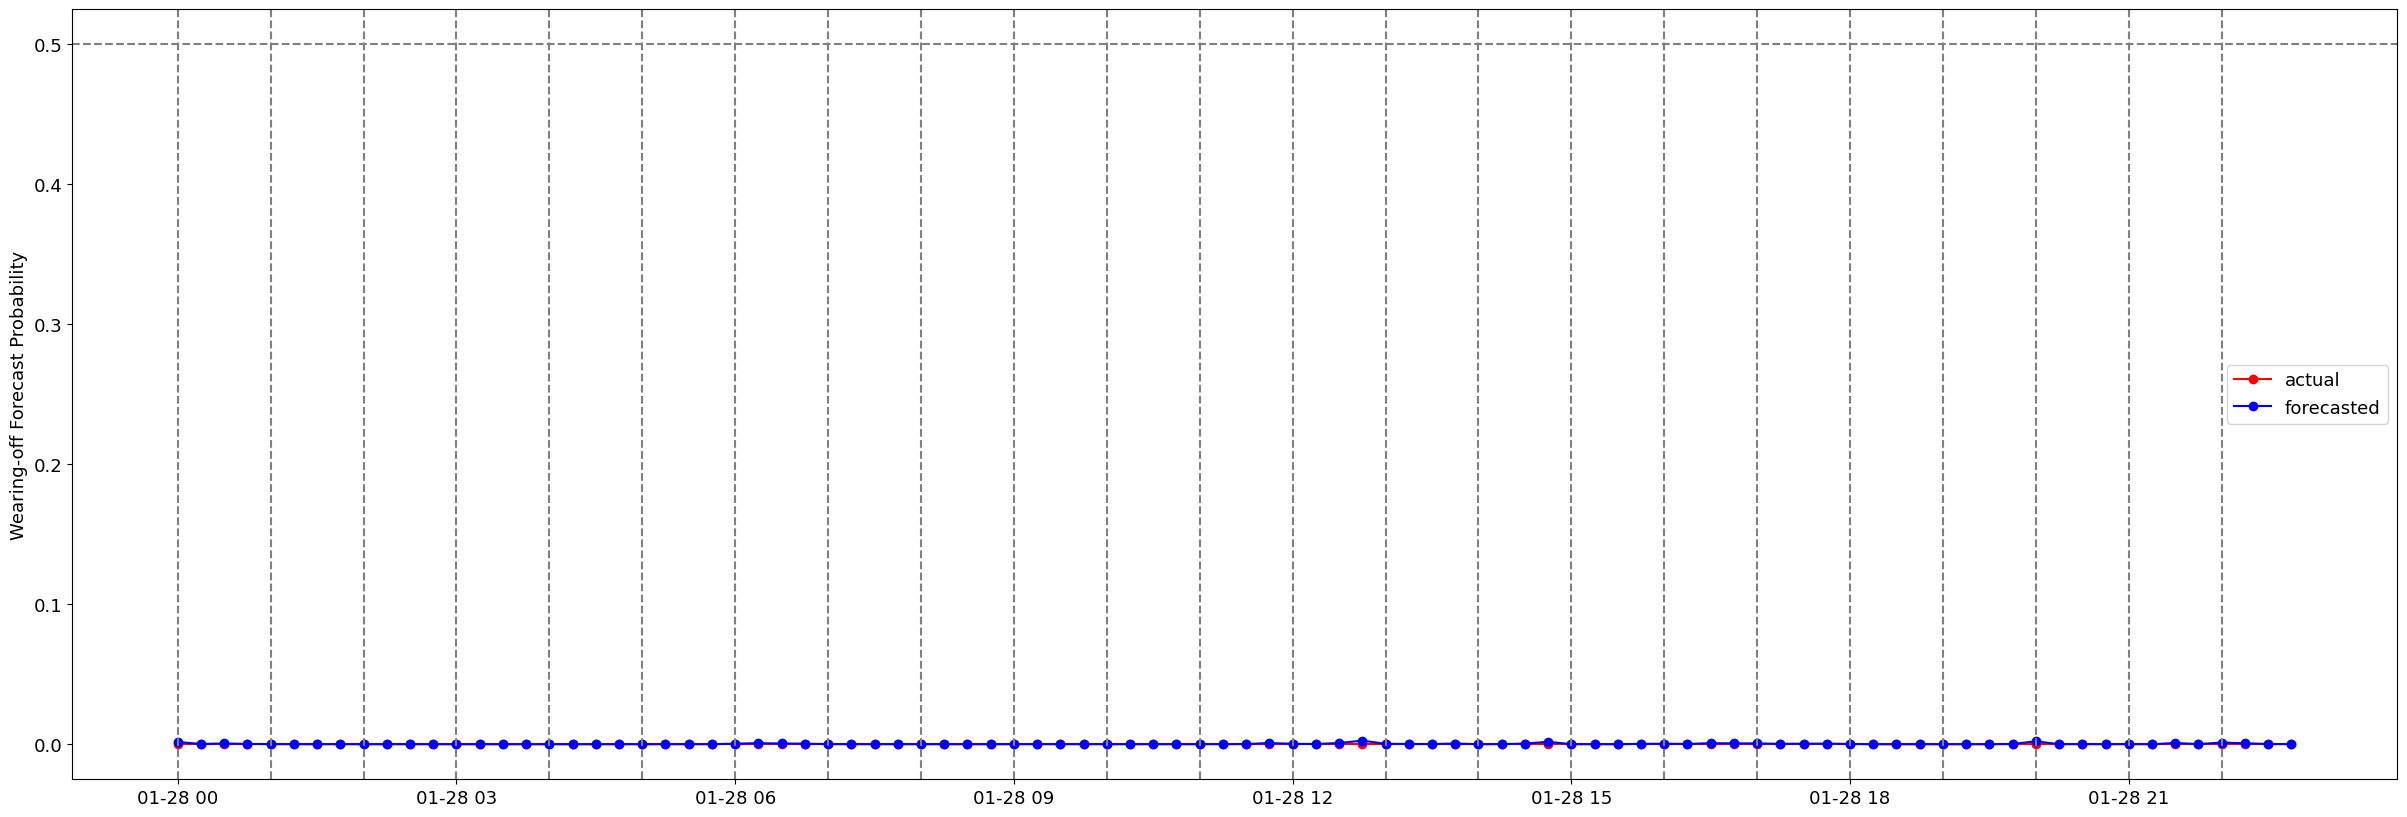

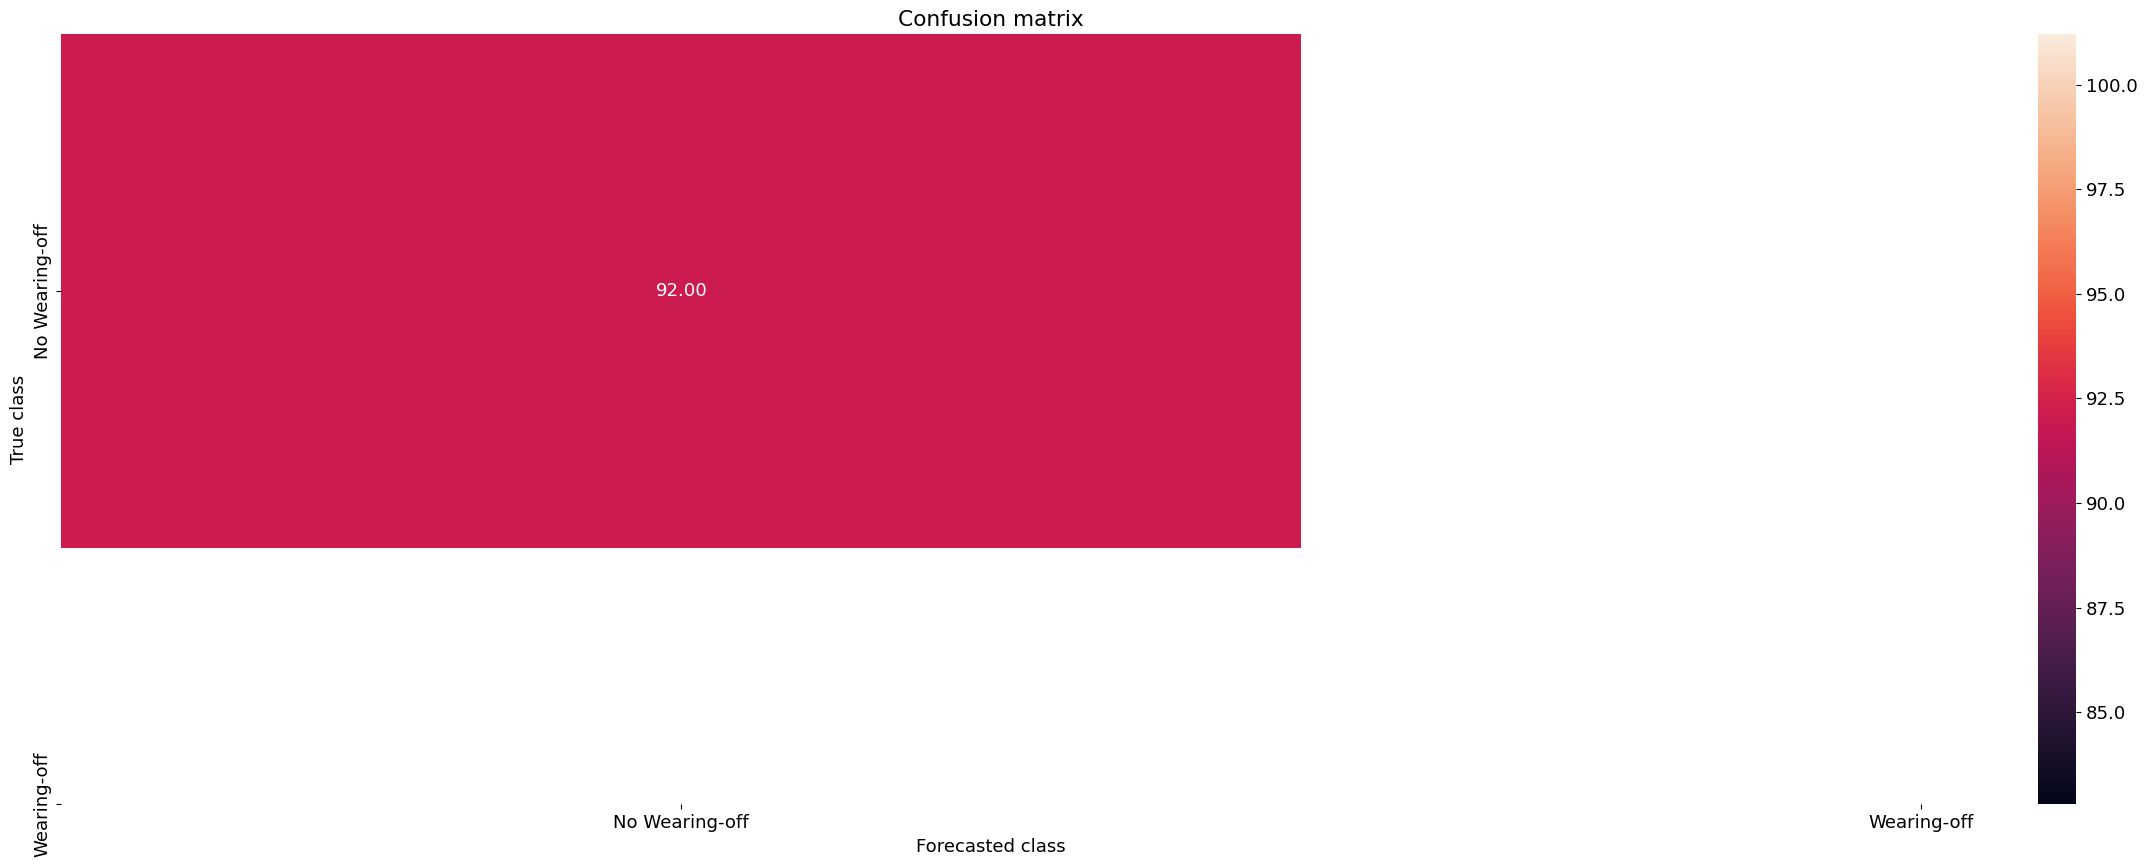

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 28
BASE XGBOOST MODEL


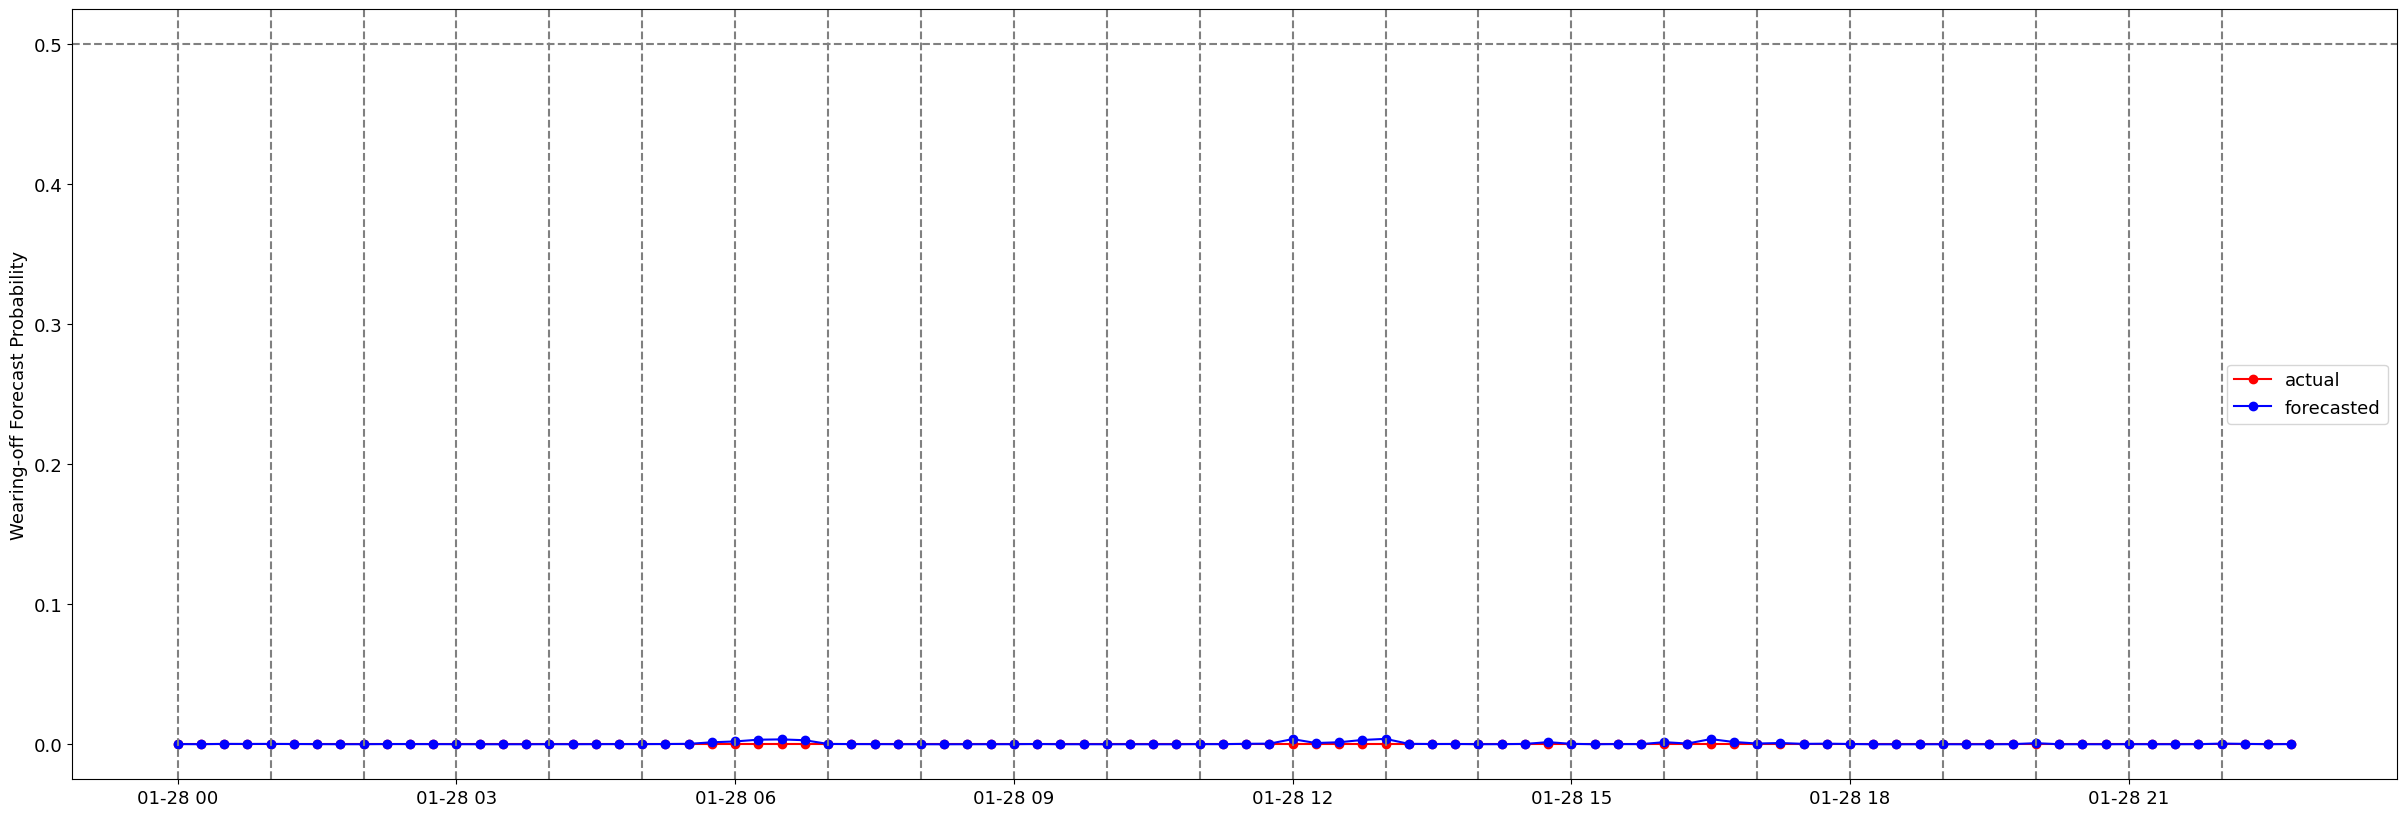

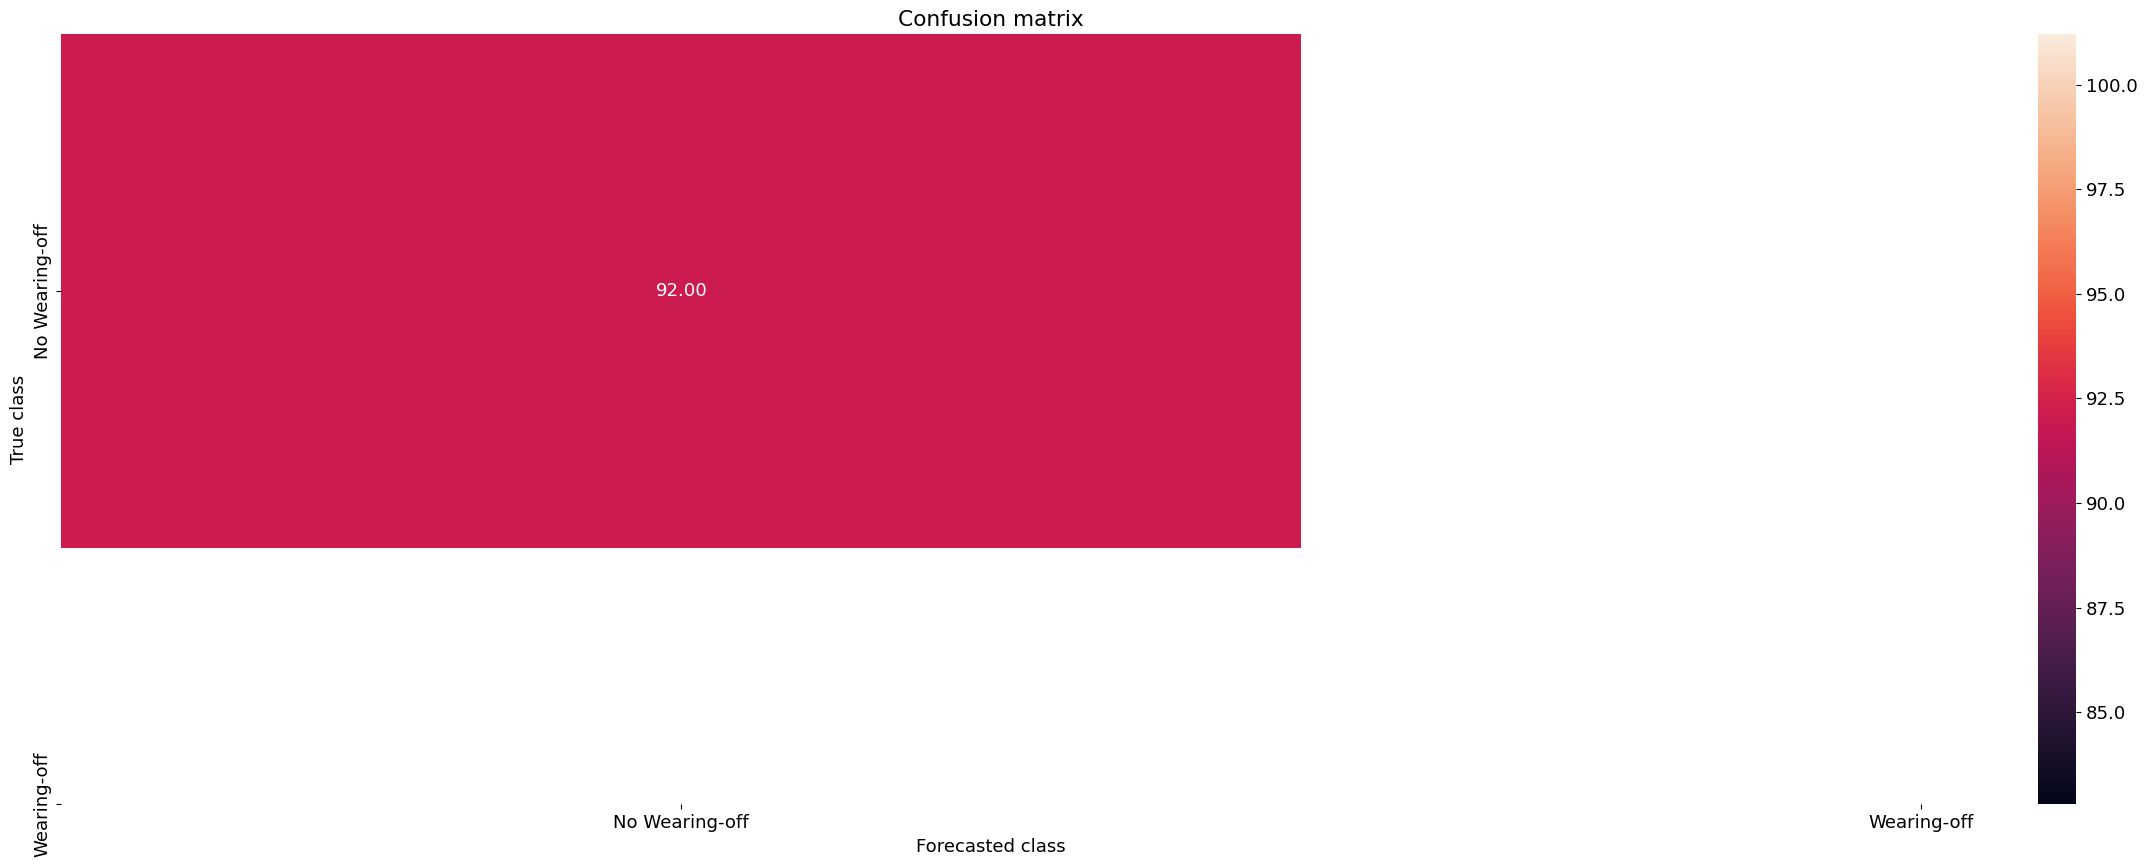

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 32
BASE XGBOOST MODEL


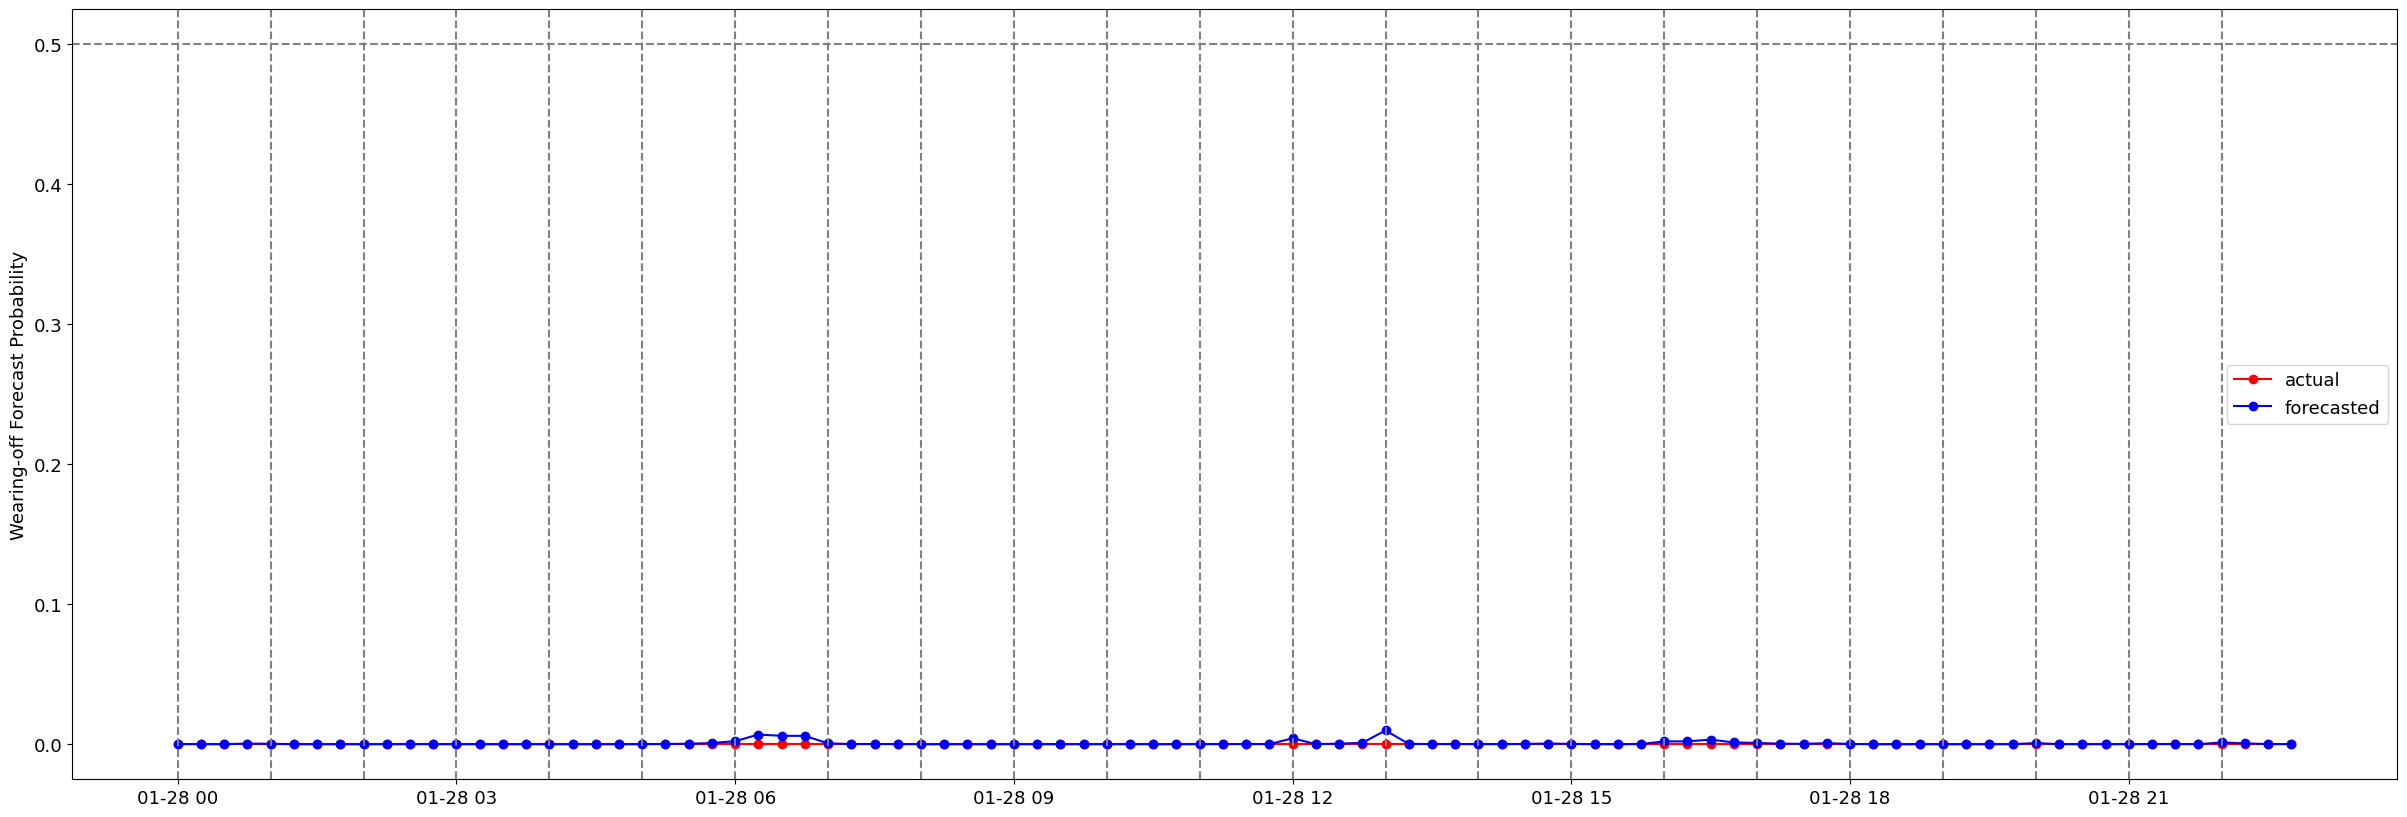

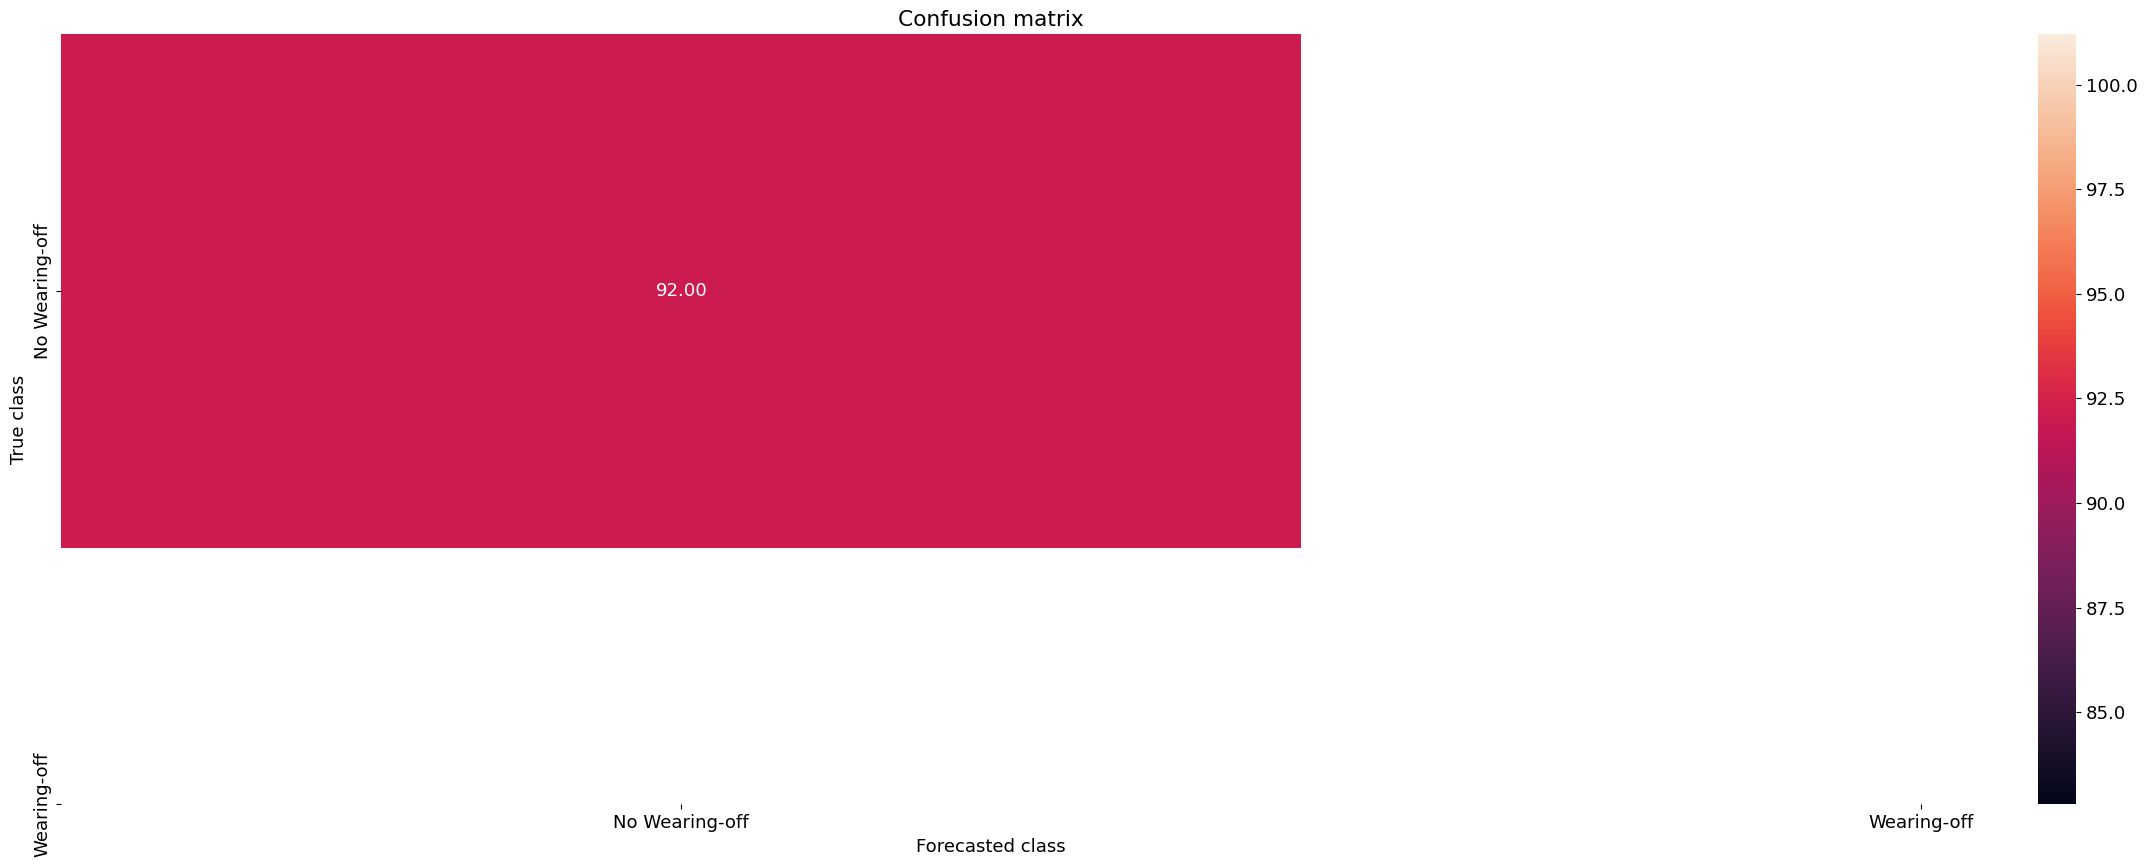

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 36
BASE XGBOOST MODEL


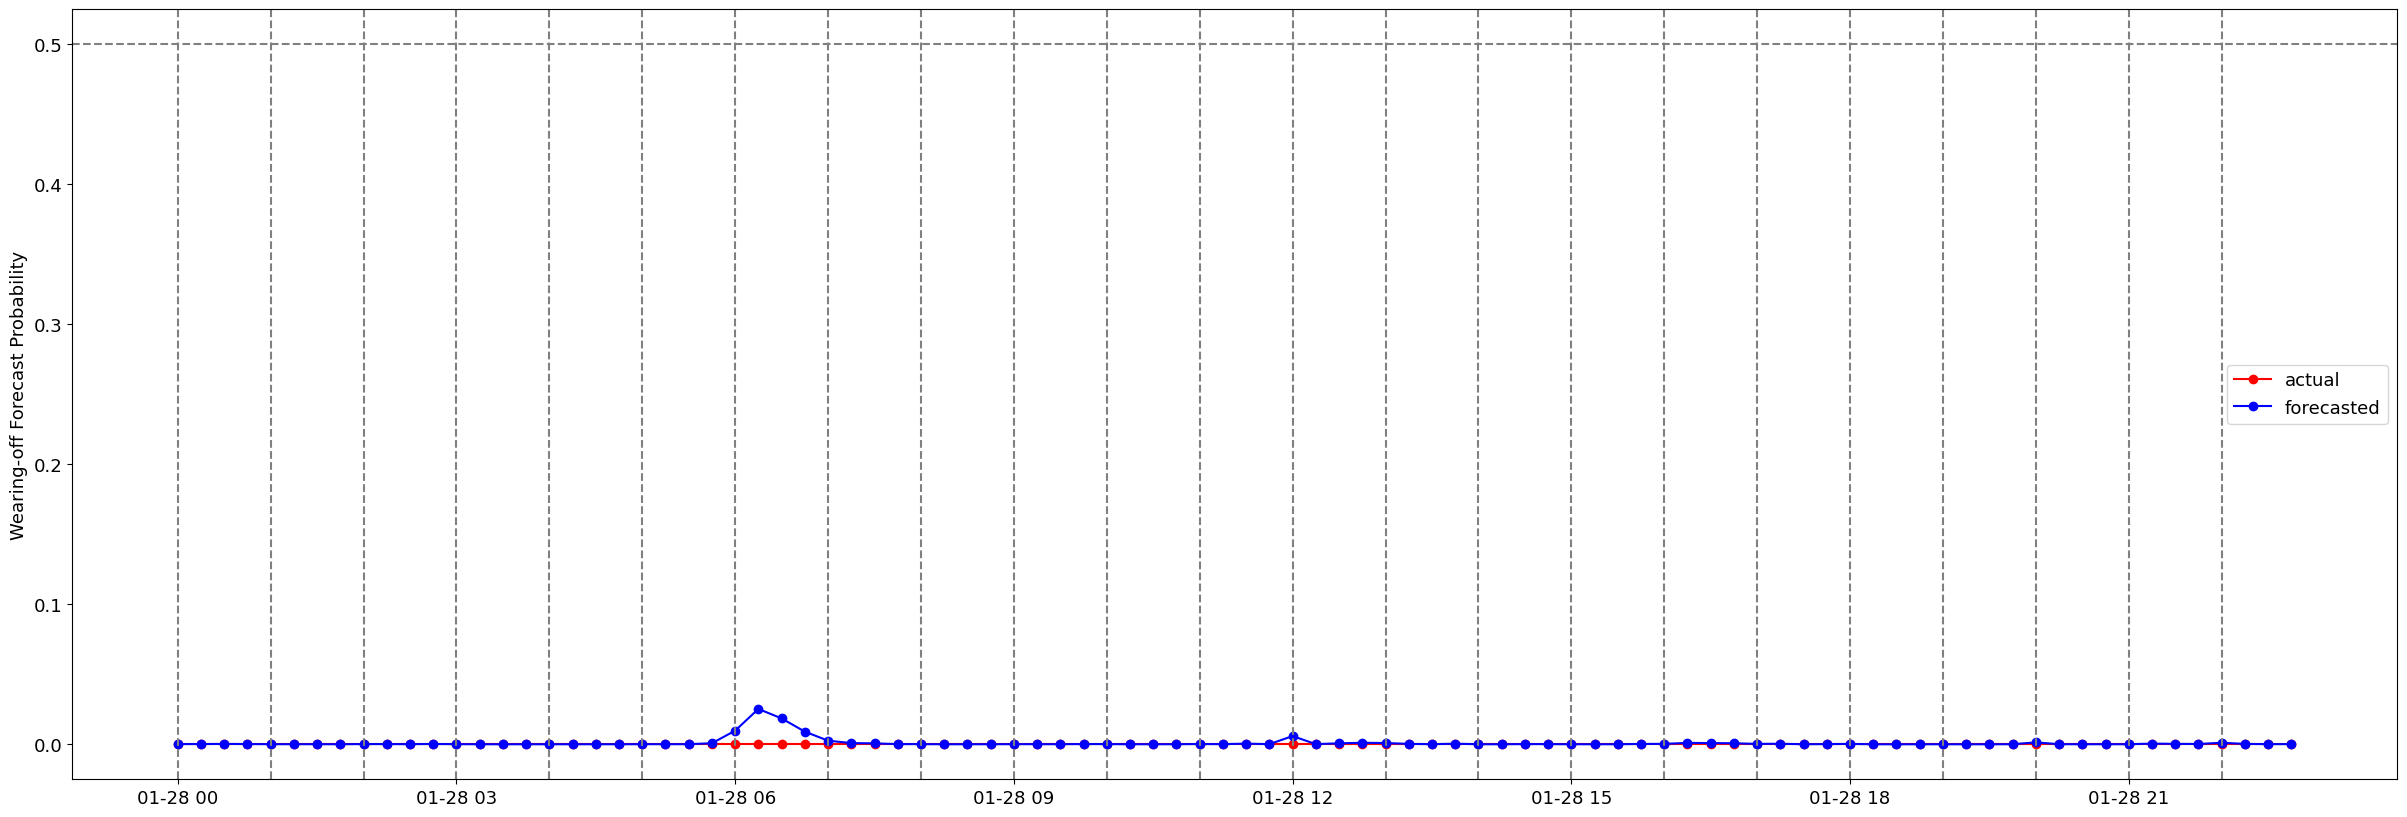

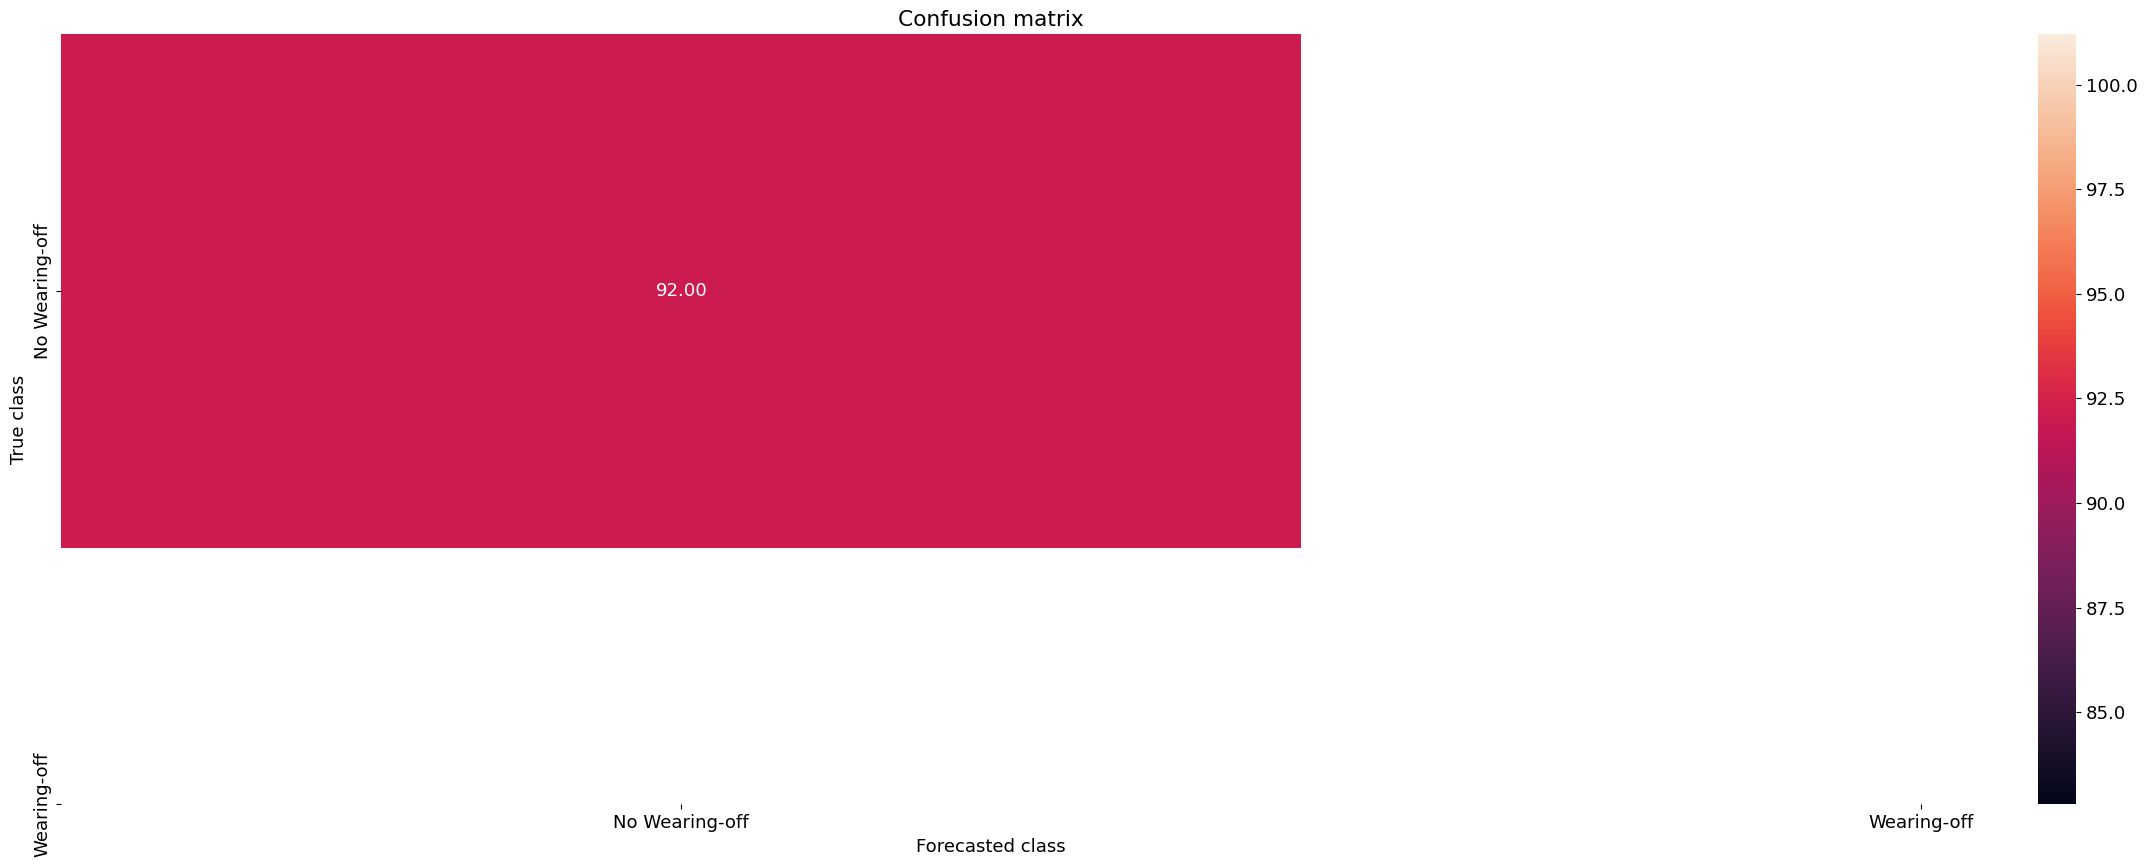

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 40
BASE XGBOOST MODEL


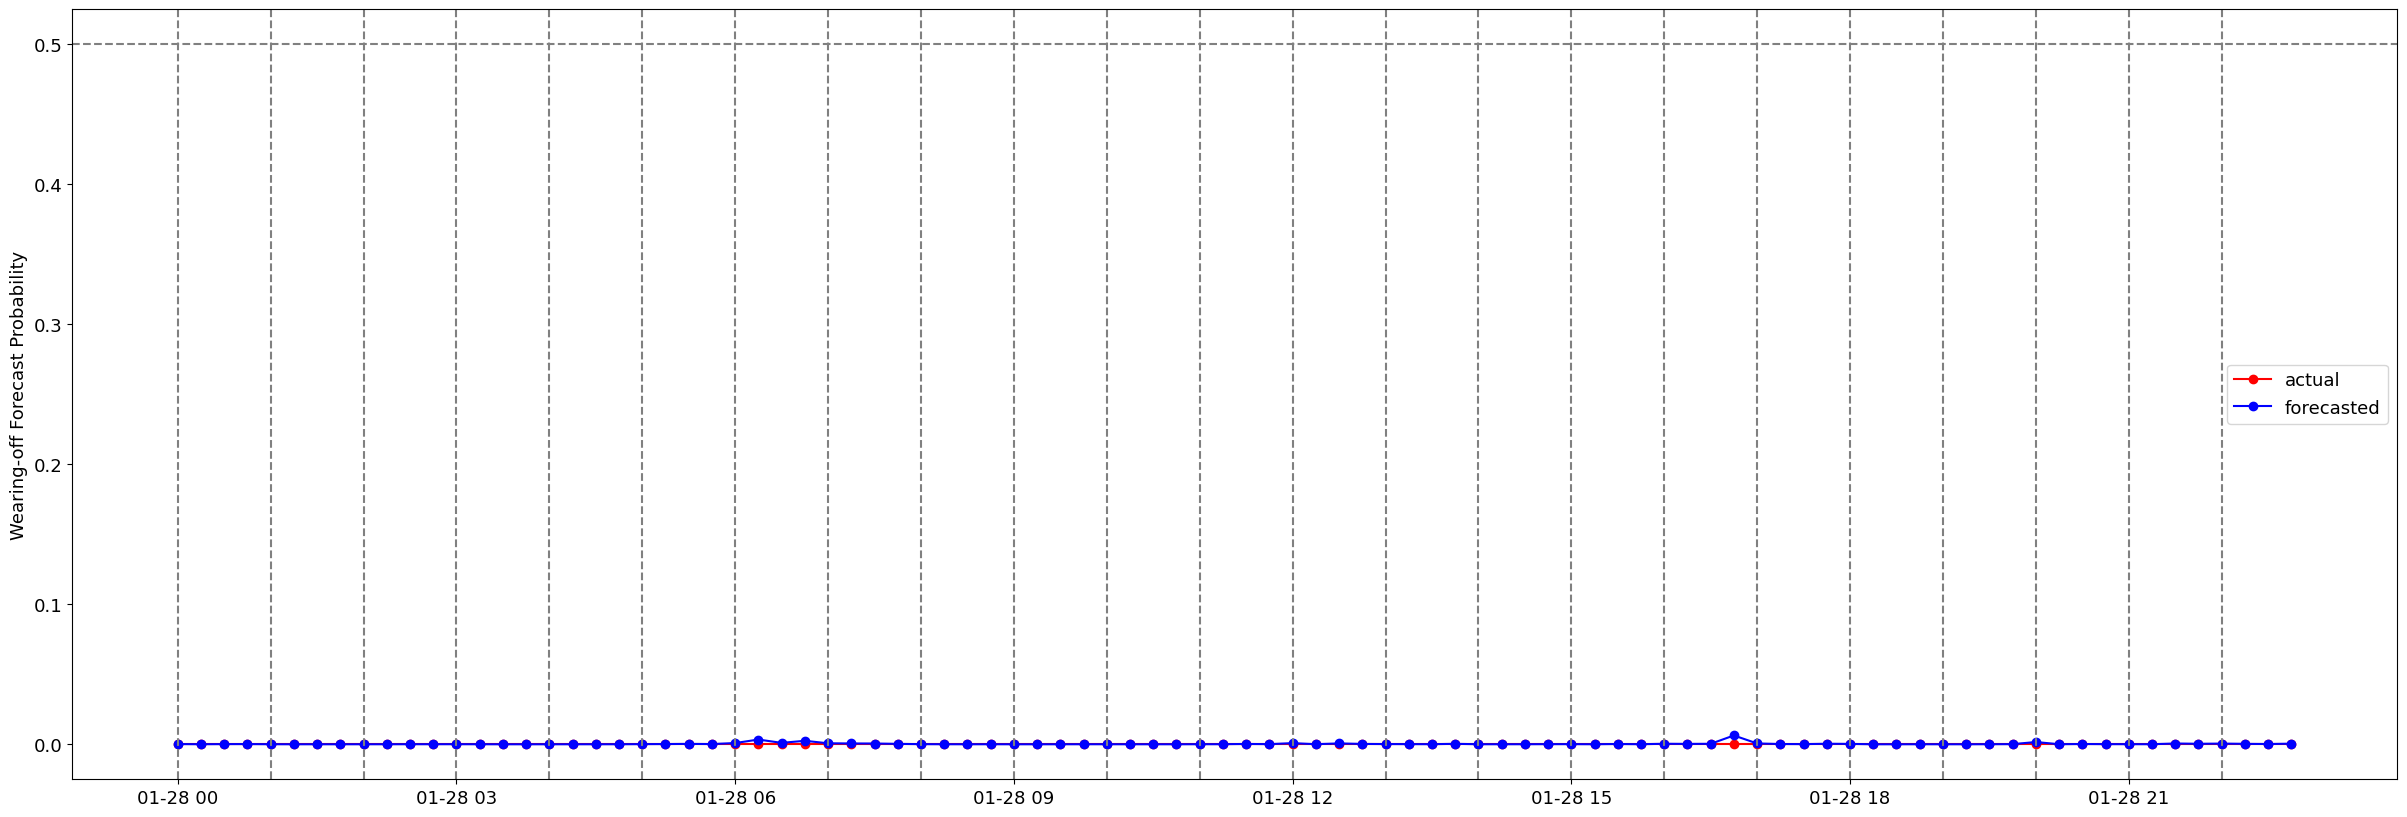

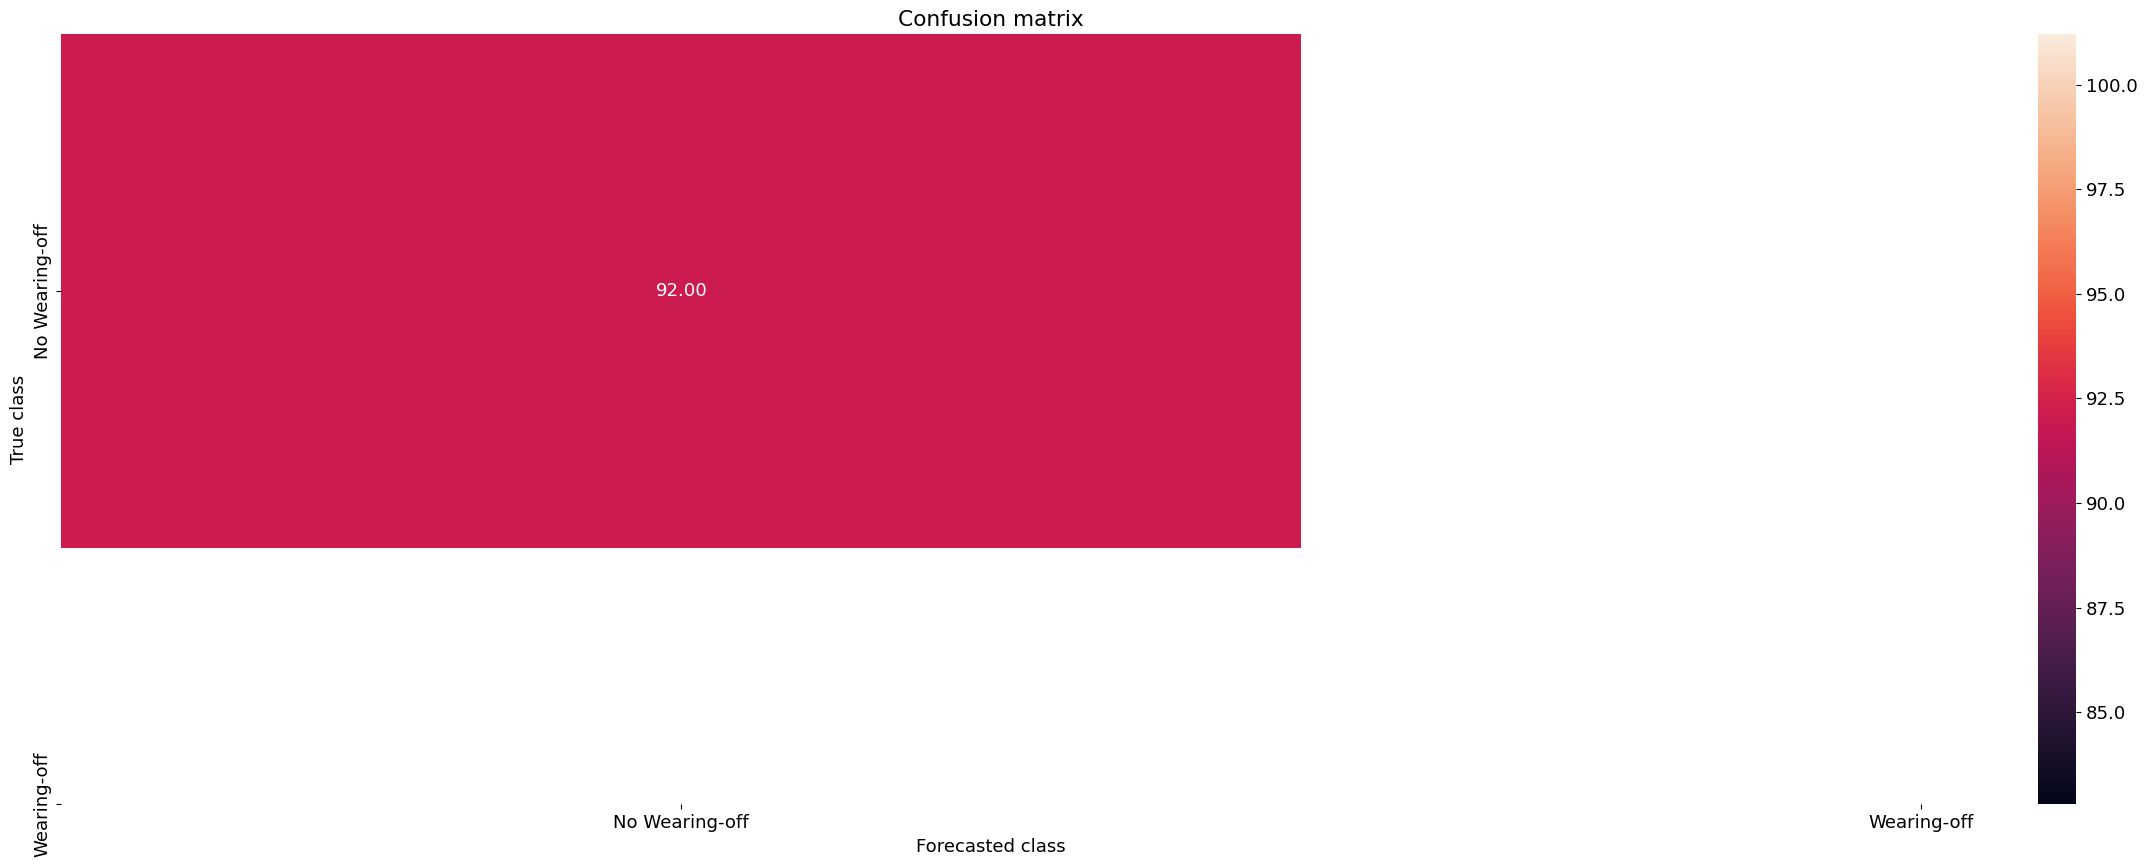

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}
N_IN: 44
BASE XGBOOST MODEL


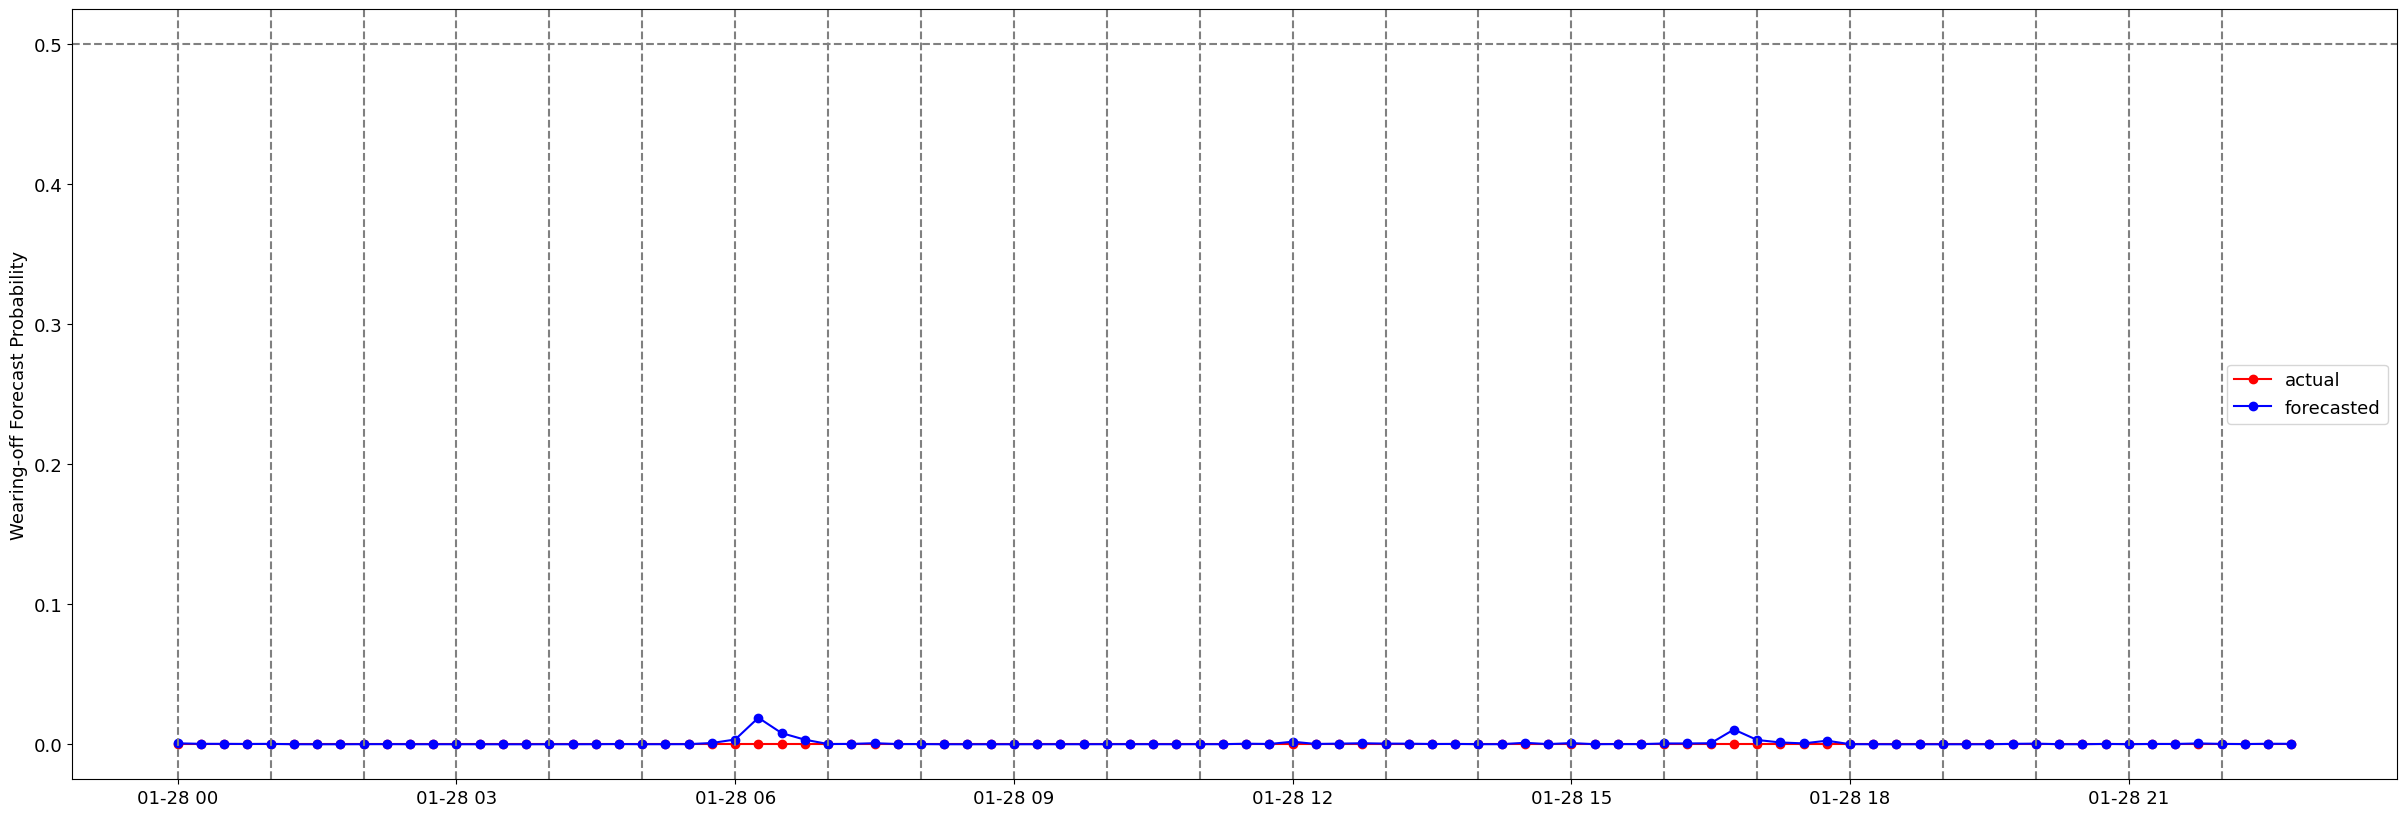

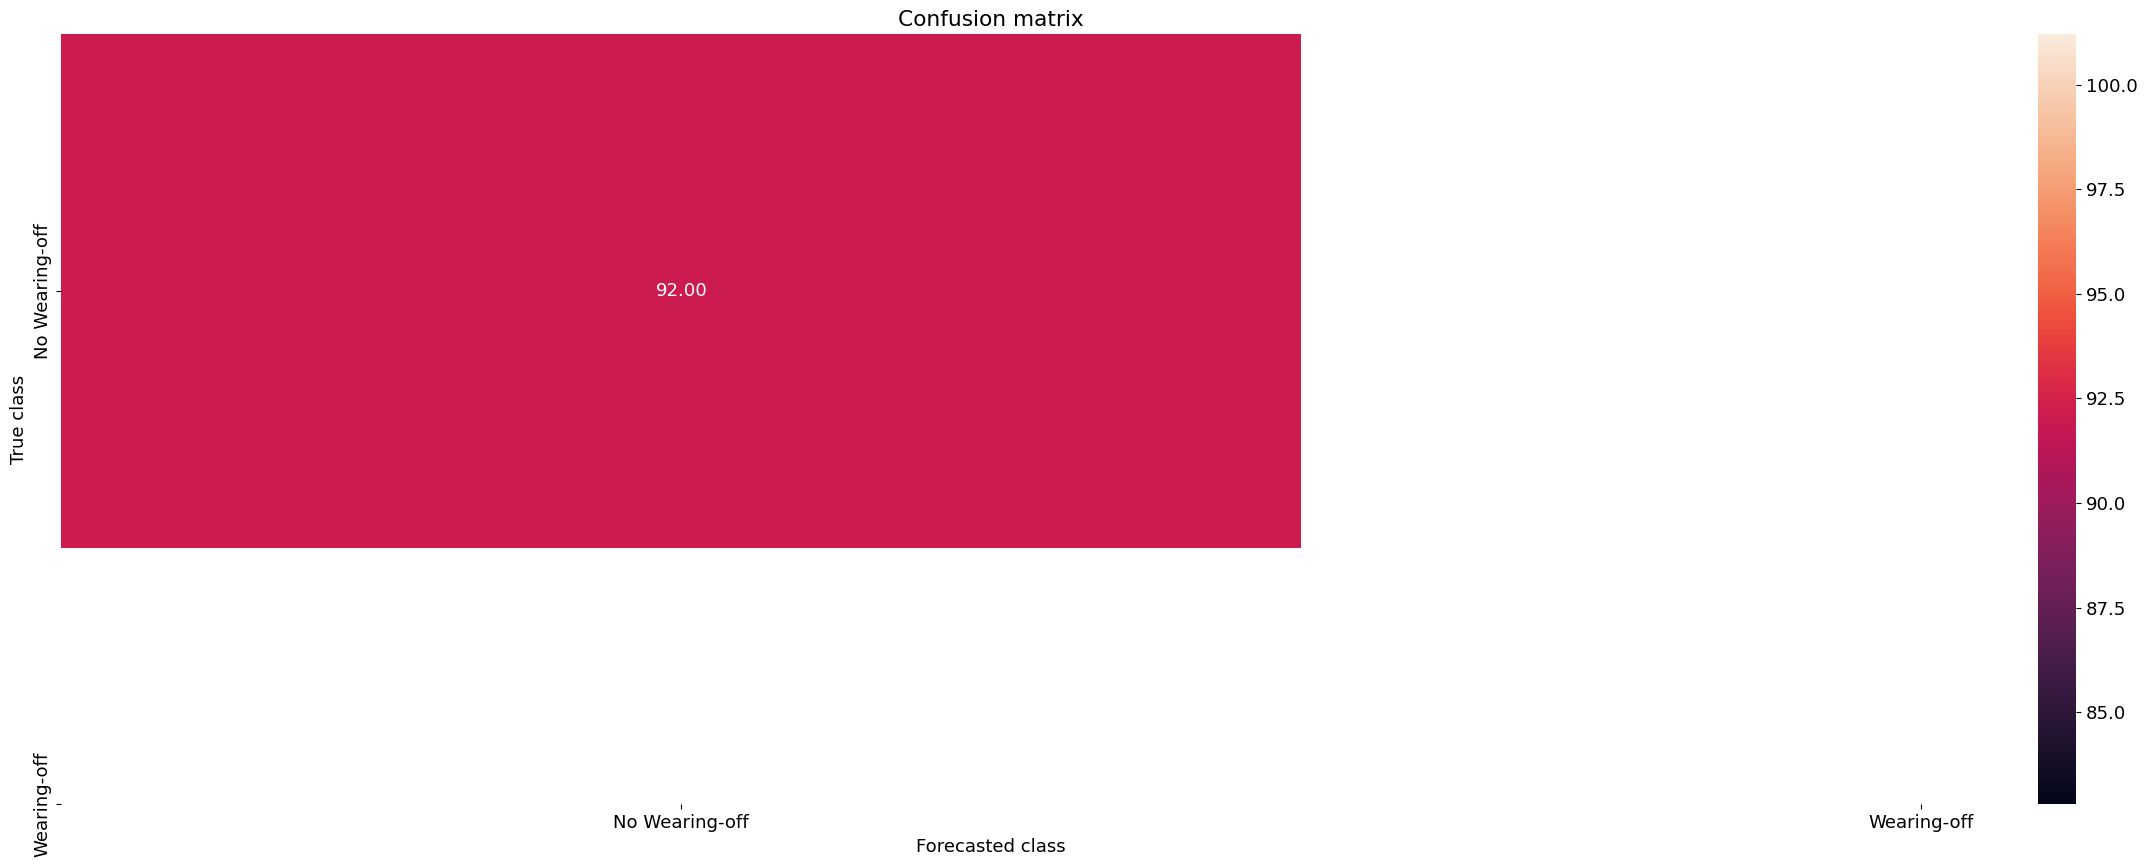

f1 score: 0.0
recall: 0.0
recall: 0.0
accuracy: 1.0
{'0.0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 92}}


In [23]:
# List from last 1 to 12 hours
N_INs = np.array(list(range(1, 12)))
fscores = []
precisions = []
recalls = []
accuracies = []
classification_reports = []

for N_IN in (SHIFT * N_INs):
  # Train DF
  reframed_train_df = series_to_supervised(train_df,
                                           n_in=N_IN,
                                           n_out=SHIFT + 1,
                                           dropnan=True)

  train_X, train_y = split_x_y(
    reframed_train_df, [f'{TARGET_COLUMN}(t+{SHIFT})'])
  # train_X = scale_data(train_X).copy()

  # Train DF
  reframed_validation_df = series_to_supervised(validation_df,
                                                n_in=N_IN,
                                                n_out=SHIFT + 1,
                                                dropnan=True)

  validation_X, validation_y = split_x_y(
    reframed_validation_df, [f'{TARGET_COLUMN}(t+{SHIFT})'])
  # validation_X = scale_data(validation_X).copy()

  # Test DF
  reframed_test_df = series_to_supervised(pd.concat([train_df.tail(N_IN),
                                                    validation_df,
                                                     ]),
                                          n_in=N_IN,
                                          n_out=SHIFT + 1,
                                          dropnan=True)
  test_X, test_y = split_x_y(reframed_test_df, [f'{TARGET_COLUMN}(t+{SHIFT})'])
  # test_X = scale_data(test_X).copy()

  ### BASE XGBOOST MODEL ###
  # create model instance
  xgb_model = XGBClassifier(random_state=4)

  # fit model
  xgb_model.fit(train_X, train_y)  # , eval_set=[(validation_X, validation_y)])

  # Make forecasts
  forecasts_output = make_forecasts(xgb_model, test_X)

  print(f'N_IN: {N_IN}')
  print(f'BASE XGBOOST MODEL')

  plot_forecast(test_y, test_X, forecasts_output)

  plot_confusion_matrix(test_y, test_X, forecasts_output)

  # evaluate predictions with f1 score, precision, recall, and accuracy
  print('f1 score:', metrics.f1_score(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off))
  print('recall:', metrics.recall_score(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off))
  print('recall:', metrics.precision_score(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off))
  print('accuracy:', metrics.accuracy_score(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off))
  print(classification_report(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off, digits=3, output_dict=True))

  fscores.append(metrics.f1_score(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off))
  precisions.append(metrics.precision_score(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off))
  recalls.append(metrics.recall_score(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off))
  accuracies.append(metrics.accuracy_score(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off))
  classification_reports.append(classification_report(
    test_y.values.ravel(),
    forecasts_output.forecasted_wearing_off, digits=3, output_dict=True))

  # ### SUBSAMPLED XGBOOST MODEL ###
  # sampling_rates = [0.1]

  # for sampling_rate in sampling_rates:
  #   subsampled_model = negative_sampling_with_log_odds_correction(
  #     train_X, train_y, sampling_rate=sampling_rate)

  #   # Make forecasts
  #   forecasts_output = make_forecasts(subsampled_model, test_X)

  #   print(f'SUBSAMPLED XGBOOST MODEL')

  #   plot_forecast(test_y, test_X, forecasts_output)

  #   plot_confusion_matrix(test_y, test_X, forecasts_output)

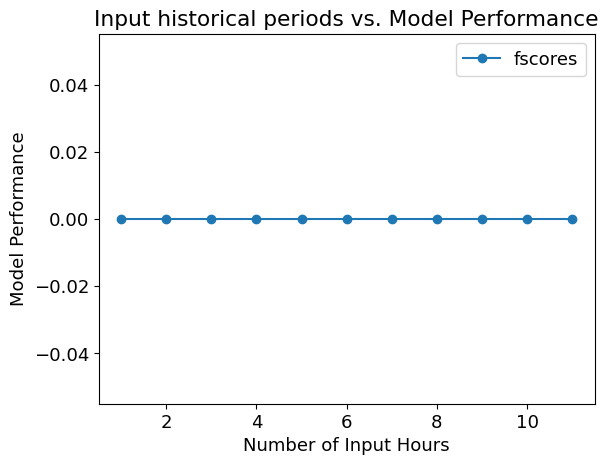

In [24]:
# Plot in x-axis the N_INs and in y-axis the fscores
pd.DataFrame(
  data={
    'fscores': fscores,
    # 'precisions': precisions,
    # 'recalls': recalls,
    # 'accuracies': accuracies
  },
  index=N_INs
).plot(
  title='Input historical periods vs. Model Performance',
  xlabel='Number of Input Hours',
  ylabel='Model Performance',
  marker='o'
)

plt.show()

In [25]:
positive_only_report = pd.DataFrame({
  "input": N_INs,
  "f1": fscores,
  "precision": precisions,
  "recall": recalls,
  "accuracy": accuracies,
}).assign(participant=USER, model='base-xgb').set_index(['participant', 'input'])

In [26]:
# flatten list of dictionary
all_classification_reports = pd.DataFrame()

for n_in, classification_report in zip(N_INs, classification_reports):
  all_classification_reports = pd.concat([
    all_classification_reports,
    pd.DataFrame(
      classification_report
    ).assign(input=n_in, participant=USER, model='base-xgb')
  ])

all_classification_reports

all_classification_reports

,0.0,accuracy,macro avg,weighted avg,input,participant,model
precision,1.0,1.0,1.0,1.0,1,participant13,base-xgb
recall,1.0,1.0,1.0,1.0,1,participant13,base-xgb
f1-score,1.0,1.0,1.0,1.0,1,participant13,base-xgb
support,92.0,1.0,92.0,92.0,1,participant13,base-xgb
precision,1.0,1.0,1.0,1.0,2,participant13,base-xgb
recall,1.0,1.0,1.0,1.0,2,participant13,base-xgb
f1-score,1.0,1.0,1.0,1.0,2,participant13,base-xgb
support,92.0,1.0,92.0,92.0,2,participant13,base-xgb
precision,1.0,1.0,1.0,1.0,3,participant13,base-xgb
recall,1.0,1.0,1.0,1.0,3,participant13,base-xgb


In [27]:
# Check if run file exists
if os.path.isfile(f'report_{run}.xlsx'):
  # Create a Pandas Excel writer using openpyxl as the engine.
  writer = pd.ExcelWriter(f'report_{run}.xlsx', engine='openpyxl',
                          mode='a', if_sheet_exists='overlay')
  # Write each dataframe to a different worksheet.
  positive_only_report.to_excel(writer, sheet_name='positive_only_report',
                                startrow=writer.sheets['positive_only_report'].max_row,
                                header=False)
  all_classification_reports.to_excel(writer, sheet_name='classification_report',
                                      startrow=writer.sheets['classification_report'].max_row,
                                      header=False)
else:
  # Create a Pandas Excel writer using openpyxl as the engine.
  writer = pd.ExcelWriter(f'report_{run}.xlsx', engine='openpyxl')

  # Write each dataframe to a different worksheet.
  positive_only_report.to_excel(writer, sheet_name='positive_only_report')
  all_classification_reports.to_excel(
    writer, sheet_name='classification_report')

writer.close()